In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    setname : list = None
    supersetname : list = None
    # model related data
    plsmodel = None
    # predicted values
    y_pred: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None
    bestinsidemethod_wtamd: float = 0.0
    bestourmethod_wtamd: float = 0.0    

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              for i in range(len(values)):
                    values[i]["setname"] = setname
                    values[i]["super_setname"] = super_setname
                  
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))

                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}    

howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSS" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData_2/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [4]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [5]:
allfeatures = set()
includeFull = True
metricsets = ["SMALL_MOLECULES","LARGE_SYSTEMS","BARRIER_HEIGHTS",\
              "INTERMOLECULAR_INTERACTIONS","INTRAMOLECULAR_INTERACTIONS"]

for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    models_results[setname].bestinsidemethod_wtamd = float("inf")
    models_results[setname].bestourmethod_wtamd = float("inf")

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        supersetlist = []
        setlist = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
            supersetlist.append(val["super_setname"])
            setlist.append(val["super_setname"]+"_"+val["setname"])
        wtmad = commonutils.wtmad_calc(supersetlist, setlist, y_pred, \
                                labels, includeFull = True)
        if wtmad["Full"] < models_results[setname].bestinsidemethod_wtamd:
            models_results[setname].bestinsidemethod_wtamd = wtmad["Full"]

        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        supersetlist = []
        setlist = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
            supersetlist.append(val["super_setname"])
            setlist.append(val["super_setname"]+"_"+val["setname"])
        wtmad = commonutils.wtmad_calc(supersetlist, setlist, y_pred, \
                                      labels, includeFull = True)
        if wtmad["Full"] < models_results[setname].bestourmethod_wtamd:
            models_results[setname].bestourmethod_wtamd = wtmad["Full"]
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

######################################################################################
# WTMAD2 Calculation for reference methods (wtmad_ref):

wtmad2_ref = commonutils.wtmad_ref(fullsetnames, metricsets,\
        howmanydifs,allvalues_perset, includeFull)

print("WTMAD-2 for inside methods", "\n")
print(wtmad2_ref, '\n')

# WTMAD2 Calculation for our methods (wtmad):

wtmad2 = commonutils.wtmad(fullsetnames, metricsets, methods, \
        allvalues_perset, includeFull)

print("WTMAD-2 for our methods", "\n")
print(wtmad2, "\n")

######################################################################################

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


WTMAD-2 for inside methods 

                      Superset  WTMAD-2_0  WTMAD-2_1  WTMAD-2_2
0              SMALL_MOLECULES      13.26      13.01      13.31
1                LARGE_SYSTEMS      21.11      17.04      16.05
2              BARRIER_HEIGHTS       8.04       8.50       8.82
3  INTERMOLECULAR_INTERACTIONS       6.27       3.70       4.05
4  INTRAMOLECULAR_INTERACTIONS       1.59       0.69       0.78
5                         Full      14.10      10.16      10.57 

WTMAD-2 for our methods 

                      Superset  WTMAD-2_PBE  WTMAD-2_PBE0  WTMAD-2_TPSS  \
0              SMALL_MOLECULES        61.11         60.96         60.11   
1                LARGE_SYSTEMS        43.15         39.99         39.54   
2              BARRIER_HEIGHTS        24.64         21.63         23.52   
3  INTERMOLECULAR_INTERACTIONS        93.31        174.37         91.12   
4  INTRAMOLECULAR_INTERACTIONS         5.39          4.50          5.06   
5                         Full        83.21  

In [6]:
# test the new def wtmad_calc(supersetlist, setlist, predicted, labels, includeFull = True):
import importlib
importlib.reload(commonutils)

supersetlist = []
setlist = []
predicted = []
labels = []
for setname in allvalues_perset:
    if setname not in list(supersetnames.keys()) + ["Full"]:
        for val in allvalues_perset[setname]:
            predicted.append(val["PBE_energydiff"]["PBE_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
            setlist.append(setname)
            pos = setname.rfind("_")
            supersetlist.append(setname[:pos])

wtmad = commonutils.wtmad_calc(supersetlist, setlist, predicted, \
                            labels, includeFull = True)
print("WTMAD for PBE method", "\n")
pp.pprint(wtmad)

for supersetname in supersetnames:
    supersetlist = []
    setlist = []
    predicted = []
    labels = []

    for setname in allvalues_perset:
        if setname.startswith(supersetname):
            if setname not in list(supersetnames.keys()) + ["Full"]:
                for val in allvalues_perset[setname]:
                    predicted.append(val["PBE_energydiff"]["PBE_FINAL_SINGLE_POINT_ENERGY"])
                    labels.append(val["label"])
                    setlist.append(setname)
                    supersetlist.append(supersetname)
        
    wtmad = commonutils.wtmad_calc(supersetlist, setlist, predicted, \
                                   labels, includeFull = True)
    print("WTMAD for PBE method in ", supersetname, "\n")
    pp.pprint(wtmad)


WTMAD for PBE method 

{
    'LARGE_SYSTEMS': numpy.float64(43.15),
    'INTRAMOLECULAR_INTERACTIONS': numpy.float64(5.39),
    'SMALL_MOLECULES': numpy.float64(61.11),
    'INTERMOLECULAR_INTERACTIONS': numpy.float64(93.31),
    'BARRIER_HEIGHTS': numpy.float64(24.64),
    'Full': numpy.float64(83.21)
}
WTMAD for PBE method in  BARRIER_HEIGHTS 

{'BARRIER_HEIGHTS': numpy.float64(24.64), 'Full': numpy.float64(24.64)}
WTMAD for PBE method in  INTRAMOLECULAR_INTERACTIONS 

{
    'INTRAMOLECULAR_INTERACTIONS': numpy.float64(5.39),
    'Full': numpy.float64(5.39)
}
WTMAD for PBE method in  SMALL_MOLECULES 

{'SMALL_MOLECULES': numpy.float64(61.11), 'Full': numpy.float64(61.11)}
WTMAD for PBE method in  INTERMOLECULAR_INTERACTIONS 

{
    'INTERMOLECULAR_INTERACTIONS': numpy.float64(93.31),
    'Full': numpy.float64(93.31)
}
WTMAD for PBE method in  LARGE_SYSTEMS 

{'LARGE_SYSTEMS': numpy.float64(43.15), 'Full': numpy.float64(43.15)}


In [7]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
models_results[setname].setname = []
models_results[setname].supersetname = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])
    models_results[setname].setname.append(val["setname"])
    models_results[setname].supersetname.append(val["super_setname"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Potential_Energy  
                    PBE0_Potential_Energy 0.99
                    TPSS_Potential_Energy 1.00
                   TPSSh_Potential_Energy 0.99
PBE_Kinetic_Energy  
                      PBE0_Kinetic_Energy 0.99
                      TPSS_Kinetic_Energy 1.00
                     TPSSh_Kinetic_Energy 0.99
PBE_E(X)  
                                PBE0_E(X) 1.00
                                TPSS_E(X) 1.00
                               TPSSh_E(X) 1.00
PBE_Two_Electron_Energy  
                  PBE_One_Electron_Energy 1.00
                    PBE_Nuclear_Repulsion 1.00
                 PBE0_One_Electron_Energy 1.00
                 PBE0_Two_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 TPSS_One_Electron_Energy 1.00
                 TPSS_Two_Electron_Energy 1.00
                   TPSS_Nuclear_Repulsion 1.00
                TPSSh_Two_Electron_Energy 1.00
                  TPSSh_Nuclear_Repulsion 1.00
                TPSSh_One_

In [8]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   TPSS_E(X)
2   TPSSh_Dispersion_correction
3   TPSS_Kinetic_Energy
4   PBE_One_Electron_Energy
5   TPSSh_Kinetic_Energy
6   PBE0_One_Electron_Energy
7   TPSSh_Two_Electron_Energy
8   TPSS_E(C)
9   TPSS_One_Electron_Energy
10   TPSSh_Nuclear_Repulsion
11   TPSS_Nuclear_Repulsion
12   PBE0_Kinetic_Energy
13   TPSS_Potential_Energy
14   PBE0_E(C)
15   PBE0_Nuclear_Repulsion
16   TPSSh_E(C)
17   PBE_Nuclear_Repulsion
18   TPSS_FINAL_SINGLE_POINT_ENERGY
19   PBE0_FINAL_SINGLE_POINT_ENERGY
20   TPSS_Two_Electron_Energy
21   PBE0_Dispersion_correction
22   PBE0_Potential_Energy
23   PBE0_Two_Electron_Energy
24   TPSS_Dispersion_correction
25   TPSSh_FINAL_SINGLE_POINT_ENERGY
26   TPSSh_E(X)
27   TPSSh_Potential_Energy
28   PBE0_E(X)
29   TPSSh_One_Electron_Energy


In [9]:
print ("Features TO USE")
idx = 1
listoffeatures_used = []
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f)
        listoffeatures_used.append(f) 
        idx += 1 

Features TO USE
1 PBE_Potential_Energy
2 PBE_E(X)
3 PBE_Two_Electron_Energy
4 PBE_Kinetic_Energy
5 PBE_Dispersion_correction
6 PBE_FINAL_SINGLE_POINT_ENERGY
7 PBE_E(C)


In [10]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    models_results[setname].setname = []
    models_results[setname].supersetname = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])
        models_results[setname].setname.append(val["setname"])
        models_results[setname].supersetname.append(val["super_setname"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

In [11]:
# CHECK WTAAD2 Calculation for reference methods (wtaad2_ref):
for setname in models_results:
    if setname in supersetnames:
        predicted = models_results[setname].y_pred_bestourmethod
        labels = models_results[setname].labels
        setlist = []
        for i, s in enumerate(models_results[setname].setname):
            ss = models_results[setname].supersetname[i]
            setlist.append(ss + "_" + s)   
        supersetlist = models_results[setname].supersetname

        wtmad = commonutils.wtmad_calc(supersetlist, setlist, predicted, labels, includeFull = False)
        print("WTMAD for ", setname, " and model ", \
              models_results[setname].bestourmethod, "\n")
        pp.pprint(wtmad)
        print(setname)

WTMAD for  BARRIER_HEIGHTS  and model  TPSSh 

{'BARRIER_HEIGHTS': numpy.float64(22.51)}
BARRIER_HEIGHTS
WTMAD for  INTRAMOLECULAR_INTERACTIONS  and model  PBE0 

{'INTRAMOLECULAR_INTERACTIONS': numpy.float64(4.5)}
INTRAMOLECULAR_INTERACTIONS
WTMAD for  SMALL_MOLECULES  and model  PBE 

{'SMALL_MOLECULES': numpy.float64(61.11)}
SMALL_MOLECULES
WTMAD for  INTERMOLECULAR_INTERACTIONS  and model  TPSSh 

{'INTERMOLECULAR_INTERACTIONS': numpy.float64(123.68)}
INTERMOLECULAR_INTERACTIONS
WTMAD for  LARGE_SYSTEMS  and model  TPSS 

{'LARGE_SYSTEMS': numpy.float64(39.54)}
LARGE_SYSTEMS


Correlation matrix


<AxesSubplot:>

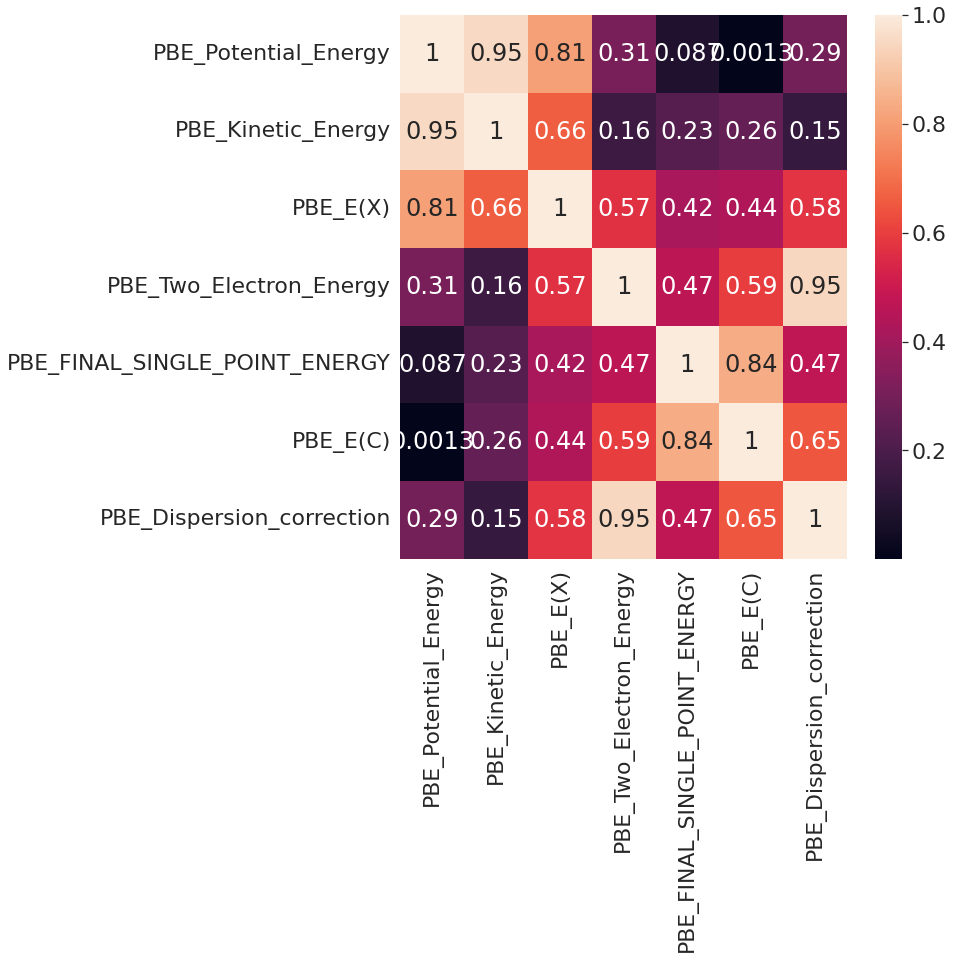

In [12]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [13]:
importlib.reload(models)

perc_split = 0.2
for setname in list(supersetnames)+["Full"]:
   print("Running PLS for dataset: ", setname)

   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
              models_results[setname].labels)
   setlist = []
   for i, s in enumerate(models_results[setname].setname):
        ss = models_results[setname].supersetname[i]
        setlist.append(ss + "_" + s)   
   supersetlist = models_results[setname].supersetname
   maxcomp = X.shape[1]
   ncomps, rmses, r2s, wtmads = \
          models.pls_model (perc_split, X, Y, supersetlist, setlist, \
          ncomp_start = 1, ncomp_max = maxcomp)
   r2max_comps = np.argmax(r2s)+1
   rmsemin_comps = np.argmin(rmses)+1
   wtmadmin_comps = np.argmin(wtmads)+1
   print("Best number of components for R2: ", r2max_comps)
   print("Best number of components for RMSE: ", rmsemin_comps)
   print("Best number of components for WTMAD: ", wtmadmin_comps)
   compstouse = wtmadmin_comps
   rmse_train, rmse_test, r2_train, \
      r2_test, rmse_full, r2_full , \
      models_results[setname].plsmodel, \
      X_train, X_test, y_train, y_test  = \
              models.pls_model (perc_split, X, Y, supersetlist, setlist, \
                                False, compstouse)
   
   models_results[setname].y_pred = \
      models_results[setname].plsmodel.predict(X) 

Running PLS for dataset:  BARRIER_HEIGHTS
Best number of components for R2:  6
Best number of components for RMSE:  6
Best number of components for WTMAD:  6
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS
Best number of components for R2:  6
Best number of components for RMSE:  6
Best number of components for WTMAD:  6
Running PLS for dataset:  SMALL_MOLECULES
Best number of components for R2:  7
Best number of components for RMSE:  7
Best number of components for WTMAD:  6
Running PLS for dataset:  INTERMOLECULAR_INTERACTIONS
Best number of components for R2:  7
Best number of components for RMSE:  7
Best number of components for WTMAD:  3
Running PLS for dataset:  LARGE_SYSTEMS
Best number of components for R2:  7
Best number of components for RMSE:  7
Best number of components for WTMAD:  6
Running PLS for dataset:  Full
Best number of components for R2:  7
Best number of components for RMSE:  7
Best number of components for WTMAD:  6


In [14]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE (superset) ," + \
      "RMSE (Full)")
pls_model_full = models_results["Full"].plsmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].fulldescriptors, \
                                    models_results["Full"].labels)
y_pred = pls_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%rmse)

for ssetname in supersetnames:
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].fulldescriptors, \
                                    models_results[ssetname].labels)
    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)    

    y_pred_full = pls_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname 
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)

        y_pred_ssetname = pls_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)
        r2_ssetname = r2_score(Y, y_pred_ssetname)

        y_pred_full = pls_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
        r2_full = r2_score(Y, y_pred_full)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%rmse_full)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE (superset) ,RMSE (Full)
1505 ,                                     Full  ,    9.227  ,   41.931  ,   30.980  ,   30.980
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,   27.068  ,    9.663  ,   17.234
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,   31.874  ,   10.634  ,   17.984
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.757  ,    8.028  ,   15.691
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    6.075  ,    8.014
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    4.198  ,    6.611
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    8.442  ,    9.449
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,   20.327  ,   41.293
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,    4.468  ,   13.776
 2

In [15]:
# test scaling Y FOR DEBUG PURPOSES
"""
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].fulldescriptors, \
                                    models_results["Full"].labels)
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))   
Y_s = scalery.transform(Y.reshape(-1, 1))
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X)
  
perc_split = 0.2
maxcomp = X_s.shape[1]

ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
              models.pls_model (perc_split, X_s, Y_s, \
              ncomp_start = 1, ncomp_max = maxcomp)
r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
compstouse = min(rmsemin_comps, r2max_comps)
rmse_train, rmse_test, r2_train, \
    r2_test, rmse_full, r2_full , \
    plsmodel, \
    X_train, X_test, y_train, y_test  = \
        models.pls_model (perc_split, X_s, Y_s, False, compstouse)
       
y_pred_s = plsmodel.predict(X_s)
y_pred = scalery.inverse_transform(y_pred_s)

rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)

print("Scaling Y")
print("RMSE %7.3f"%rmse, " , ", "R2 %7.3f"%r2)  
"""

'\nX, Y, features_names =     commonutils.build_XY_matrix (models_results["Full"].fulldescriptors,                                     models_results["Full"].labels)\nscalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))   \nY_s = scalery.transform(Y.reshape(-1, 1))\nscalerx = preprocessing.StandardScaler().fit(X)\nX_s = scalerx.transform(X)\n  \nperc_split = 0.2\nmaxcomp = X_s.shape[1]\n\nncomps, rmses_test, rmses_train, r2s_test, r2s_train =               models.pls_model (perc_split, X_s, Y_s,               ncomp_start = 1, ncomp_max = maxcomp)\nr2max_comps = np.argmax(r2s_test)+1\nrmsemin_comps = np.argmin(rmses_test)+1\ncompstouse = min(rmsemin_comps, r2max_comps)\nrmse_train, rmse_test, r2_train,     r2_test, rmse_full, r2_full ,     plsmodel,     X_train, X_test, y_train, y_test  =         models.pls_model (perc_split, X_s, Y_s, False, compstouse)\n       \ny_pred_s = plsmodel.predict(X_s)\ny_pred = scalery.inverse_transform(y_pred_s)\n\nrmse = mean_squared_error(Y, y_p

WTAMD2                     10.350
WTAMD2 (bestinsidemethod)   8.040
WTAMD2    (bestourmethod)  21.630
RMSE           (ssetname)   9.663
RMSE               (Full)  17.234
RMSE   (bestinsidemethod)   8.201
RMSE      (bestourmethod)  27.068


<Figure size 720x720 with 0 Axes>

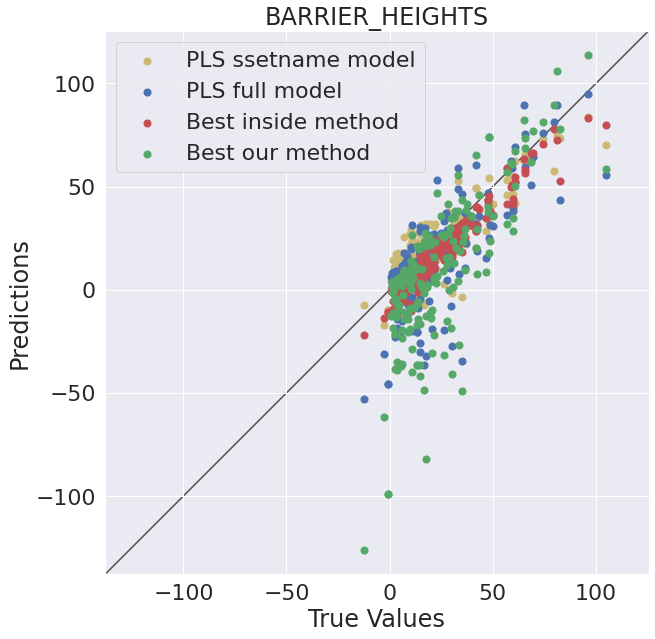

RMSE           (ssetname)  10.634
RMSE               (Full)  17.984
RMSE   (bestinsidemethod)  10.387
RMSE      (bestourmethod)  31.874


<Figure size 720x720 with 0 Axes>

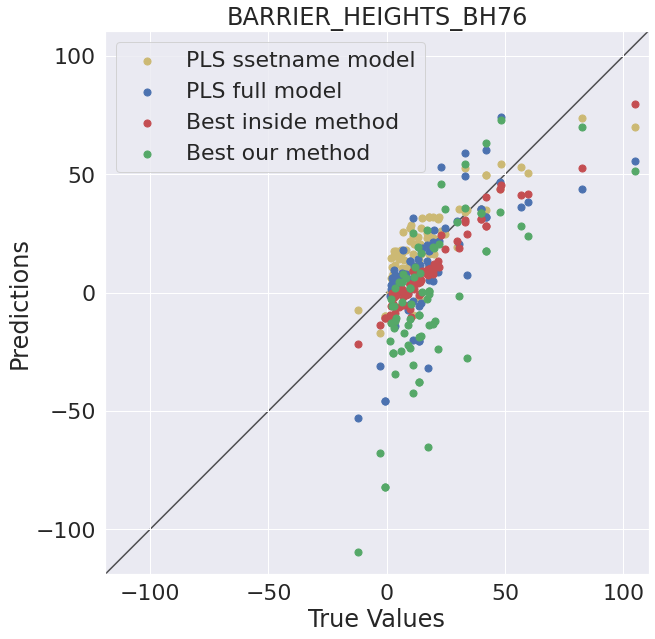

RMSE           (ssetname)   8.028
RMSE               (Full)  15.691
RMSE   (bestinsidemethod)   9.191
RMSE      (bestourmethod)  14.757


<Figure size 720x720 with 0 Axes>

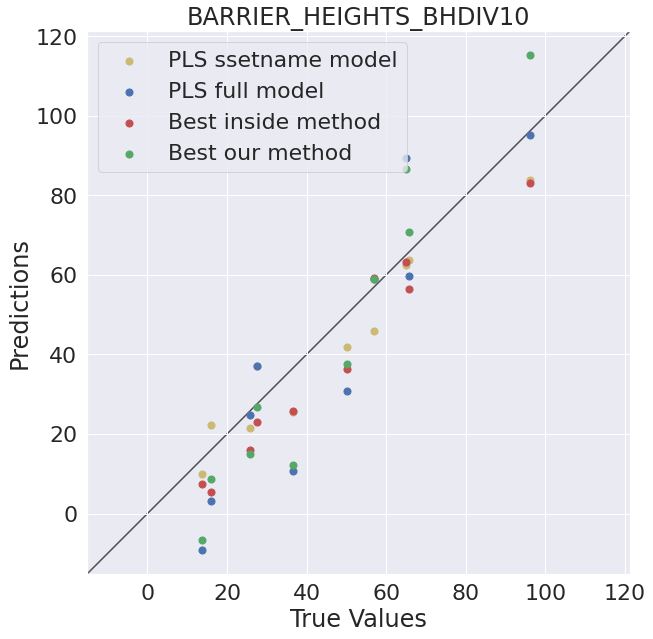

RMSE           (ssetname)   6.075
RMSE               (Full)   8.014
RMSE   (bestinsidemethod)   4.407
RMSE      (bestourmethod)  17.811


<Figure size 720x720 with 0 Axes>

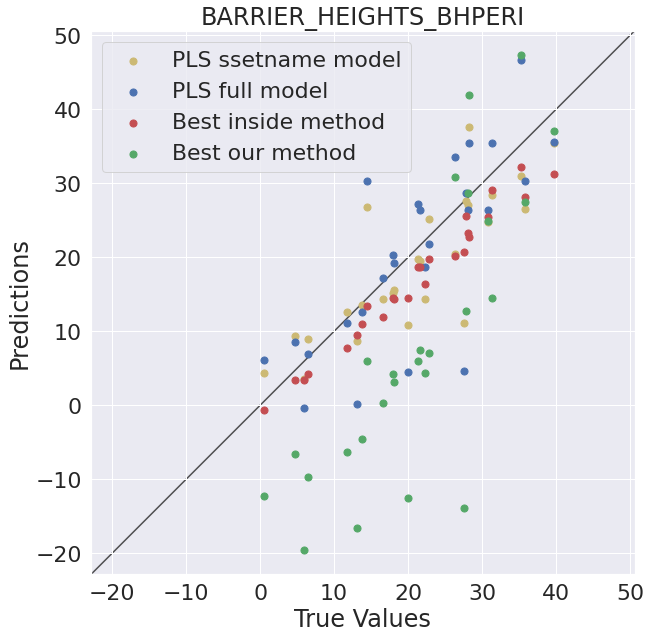

RMSE           (ssetname)   4.198
RMSE               (Full)   6.611
RMSE   (bestinsidemethod)   0.611
RMSE      (bestourmethod)   2.686


<Figure size 720x720 with 0 Axes>

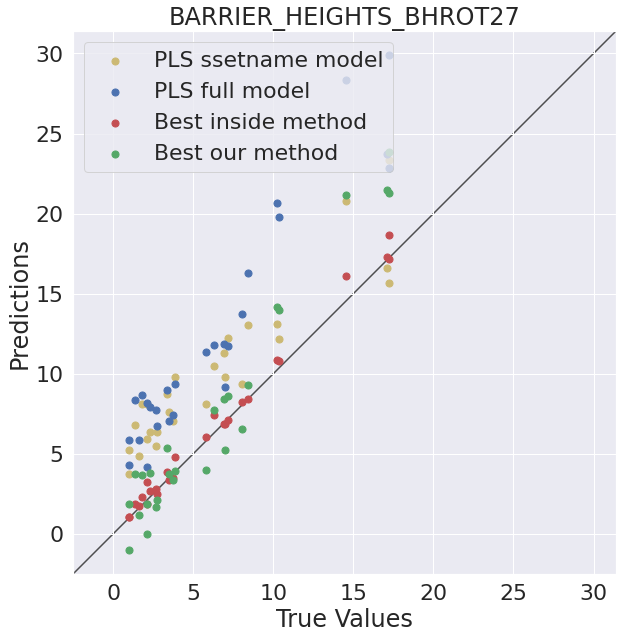

RMSE           (ssetname)   8.442
RMSE               (Full)   9.449
RMSE   (bestinsidemethod)   2.658
RMSE      (bestourmethod)   5.711


<Figure size 720x720 with 0 Axes>

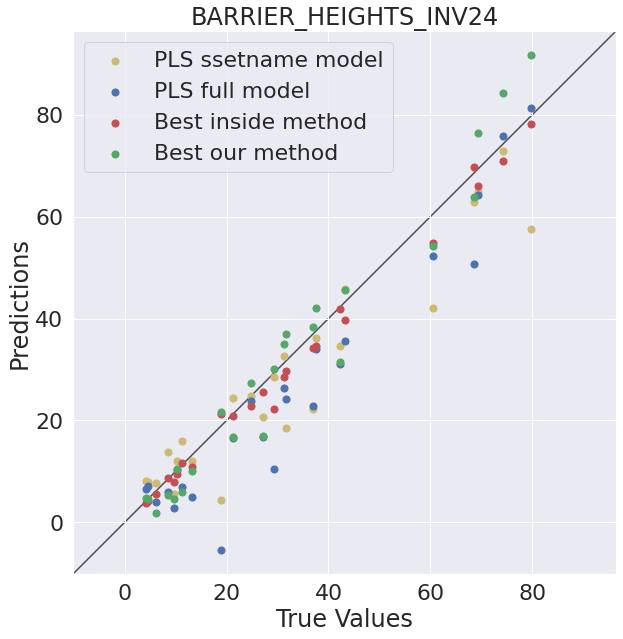

RMSE           (ssetname)  20.327
RMSE               (Full)  41.293
RMSE   (bestinsidemethod)  11.730
RMSE      (bestourmethod)  49.956


<Figure size 720x720 with 0 Axes>

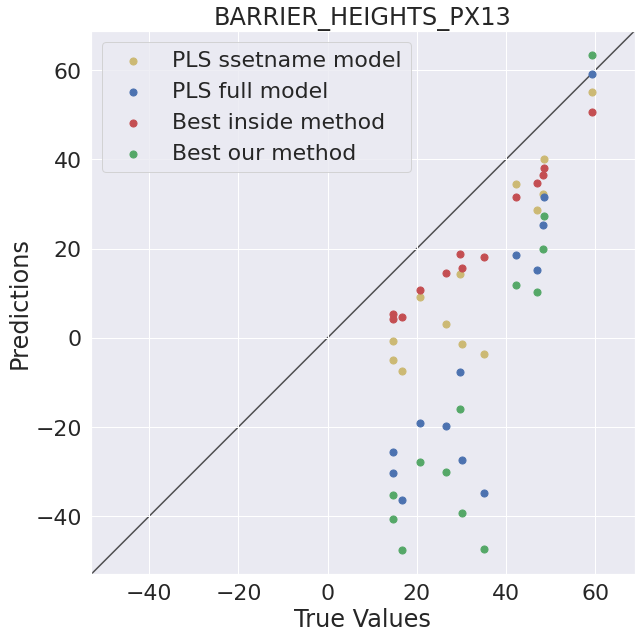

RMSE           (ssetname)   4.468
RMSE               (Full)  13.776
RMSE   (bestinsidemethod)   8.999
RMSE      (bestourmethod)  24.302


<Figure size 720x720 with 0 Axes>

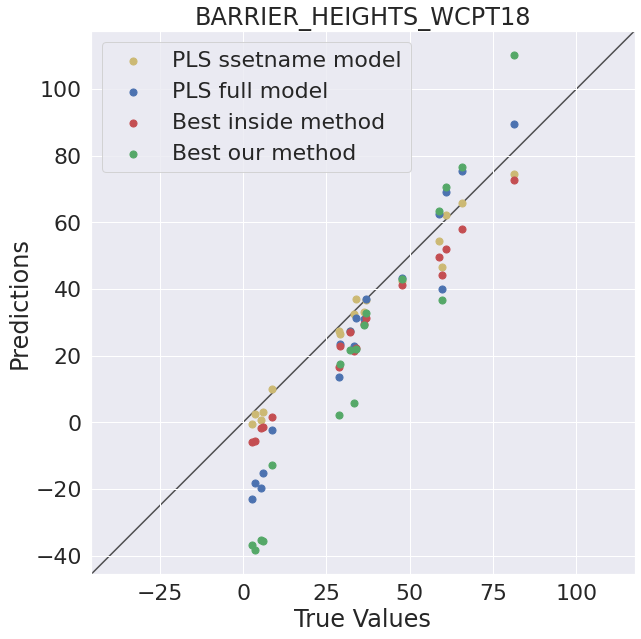

WTAMD2                      1.400
WTAMD2 (bestinsidemethod)   0.690
WTAMD2    (bestourmethod)   4.500
RMSE           (ssetname)   2.417
RMSE               (Full)  10.077
RMSE   (bestinsidemethod)   0.873
RMSE      (bestourmethod)   4.499


<Figure size 720x720 with 0 Axes>

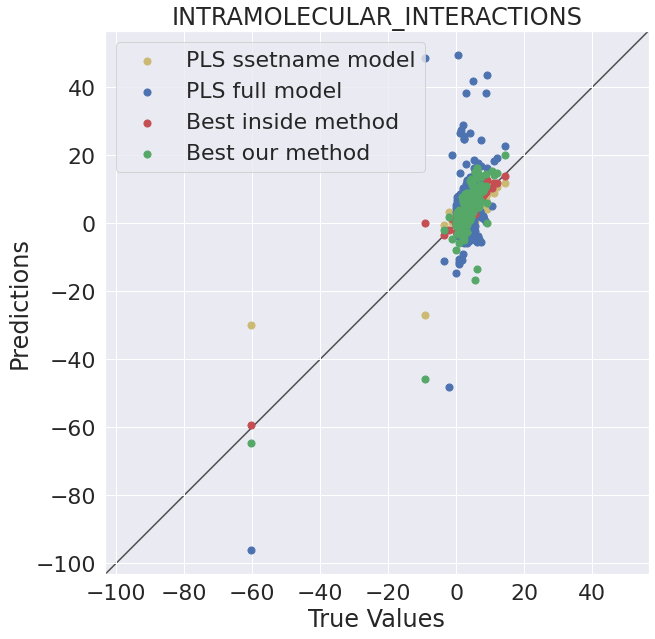

RMSE           (ssetname)   0.484
RMSE               (Full)   6.126
RMSE   (bestinsidemethod)   0.090
RMSE      (bestourmethod)   1.250


<Figure size 720x720 with 0 Axes>

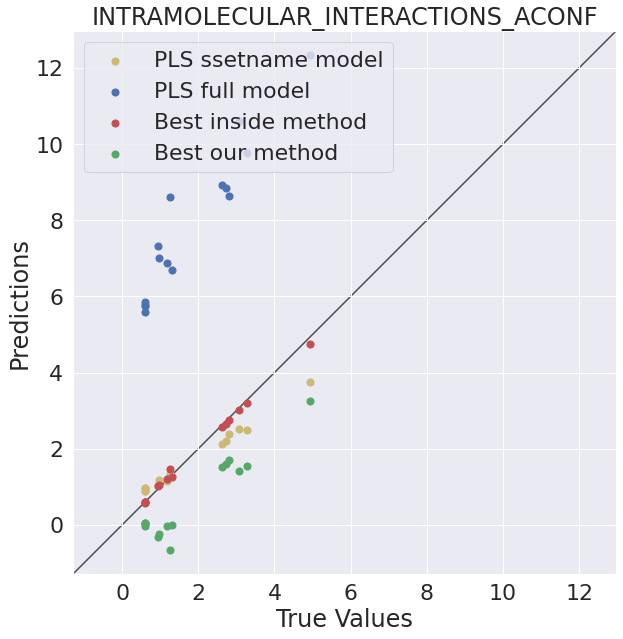

RMSE           (ssetname)   0.819
RMSE               (Full)   5.198
RMSE   (bestinsidemethod)   0.375
RMSE      (bestourmethod)   2.559


<Figure size 720x720 with 0 Axes>

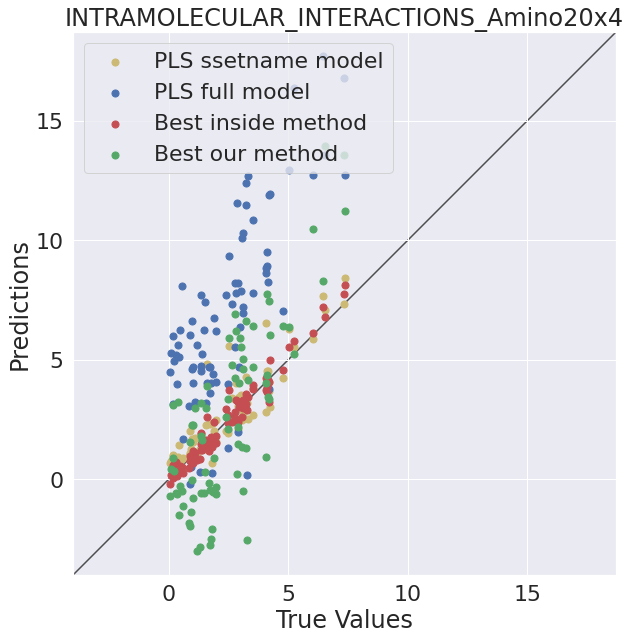

RMSE           (ssetname)   0.868
RMSE               (Full)   6.450
RMSE   (bestinsidemethod)   0.349
RMSE      (bestourmethod)   4.486


<Figure size 720x720 with 0 Axes>

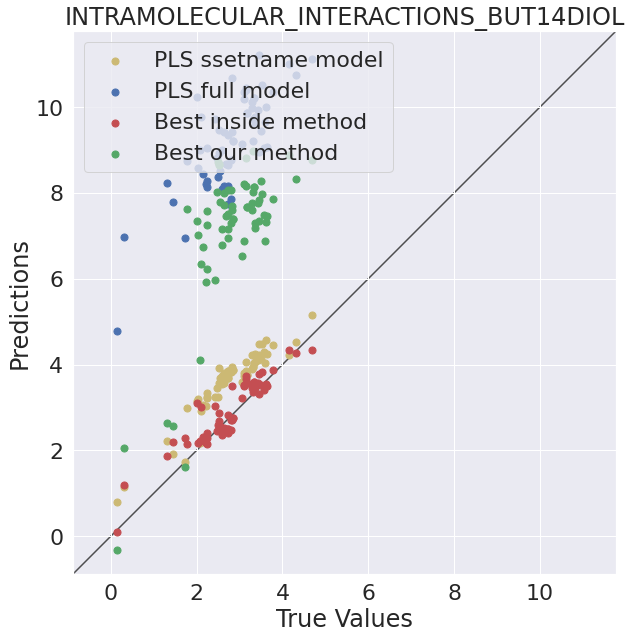

RMSE           (ssetname)   2.303
RMSE               (Full)   5.152
RMSE   (bestinsidemethod)   0.450
RMSE      (bestourmethod)   1.496


<Figure size 720x720 with 0 Axes>

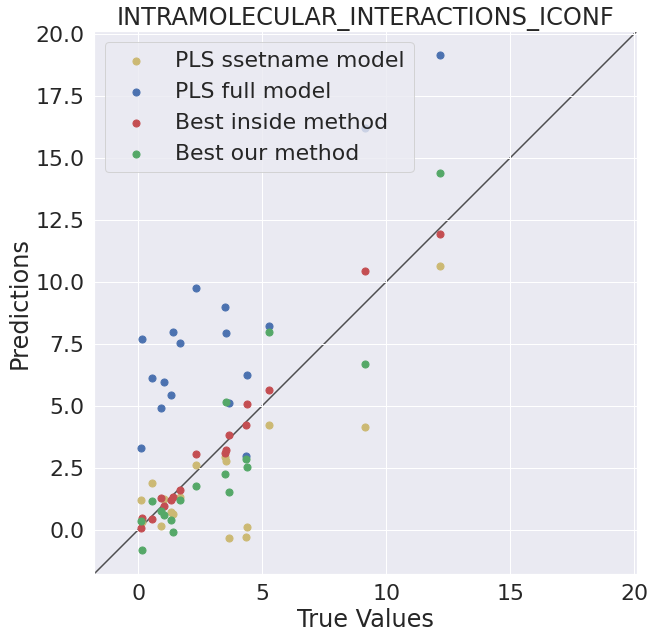

RMSE           (ssetname)  14.578
RMSE               (Full)  37.473
RMSE   (bestinsidemethod)   4.154
RMSE      (bestourmethod)  11.849


<Figure size 720x720 with 0 Axes>

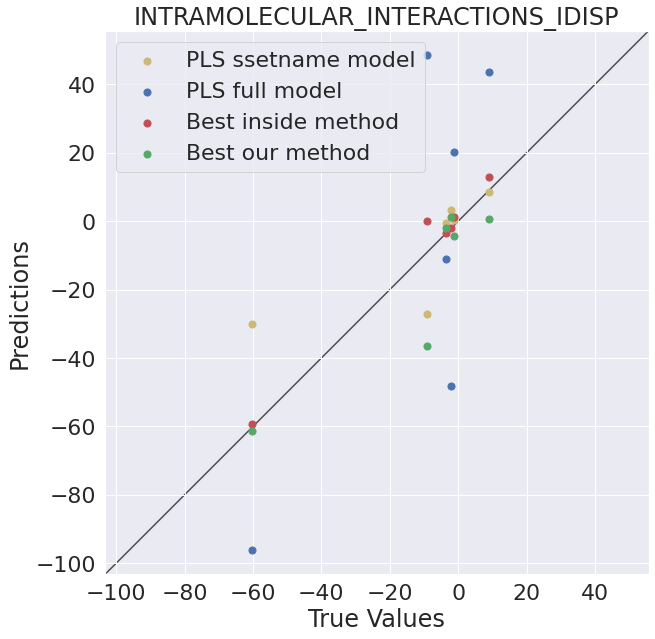

RMSE           (ssetname)   1.072
RMSE               (Full)   6.526
RMSE   (bestinsidemethod)   0.480
RMSE      (bestourmethod)   1.902


<Figure size 720x720 with 0 Axes>

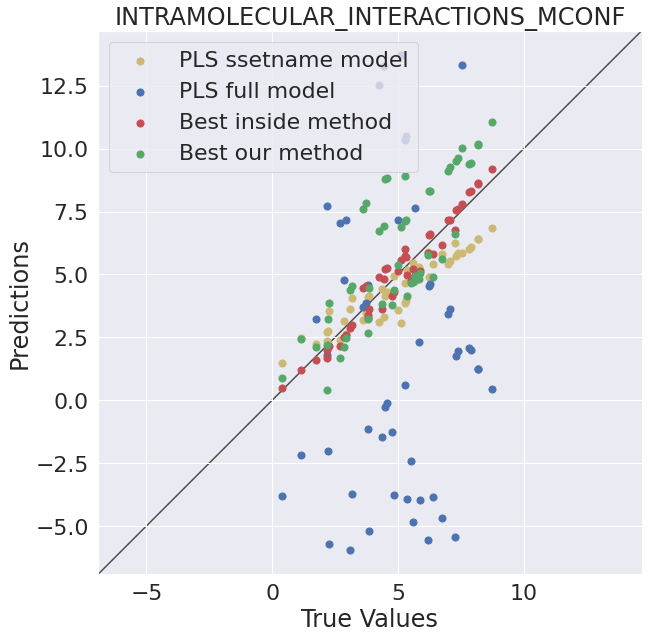

RMSE           (ssetname)   1.708
RMSE               (Full)  14.594
RMSE   (bestinsidemethod)   1.286
RMSE      (bestourmethod)   4.008


<Figure size 720x720 with 0 Axes>

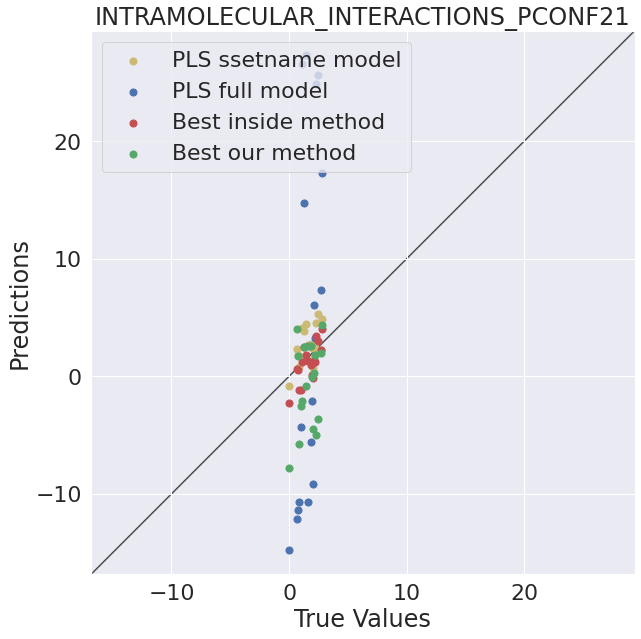

RMSE           (ssetname)   1.721
RMSE               (Full)   6.664
RMSE   (bestinsidemethod)   0.472
RMSE      (bestourmethod)  10.187


<Figure size 720x720 with 0 Axes>

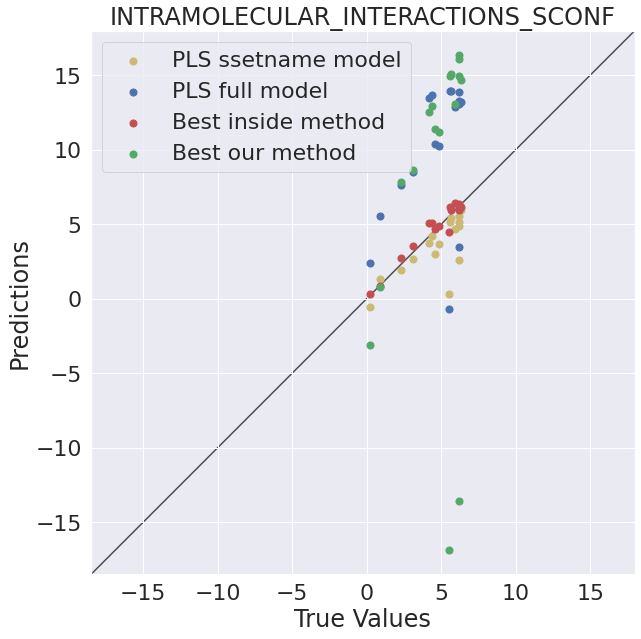

RMSE           (ssetname)   1.720
RMSE               (Full)  19.253
RMSE   (bestinsidemethod)   0.563
RMSE      (bestourmethod)   3.427


<Figure size 720x720 with 0 Axes>

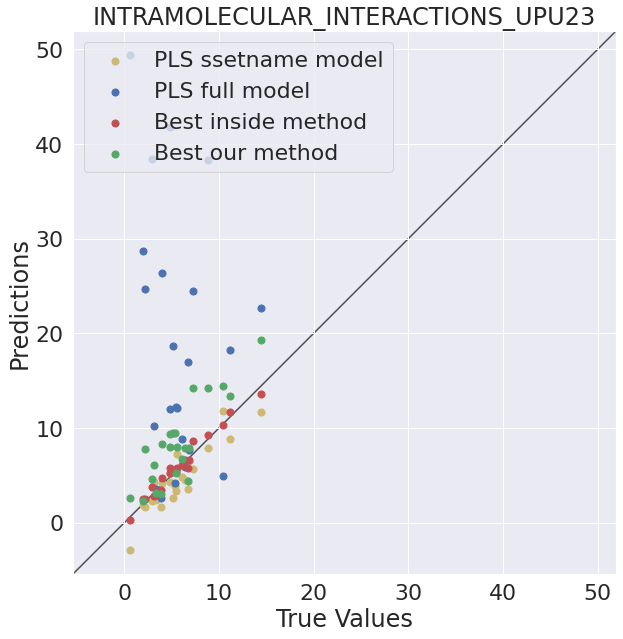

WTAMD2                     47.840
WTAMD2 (bestinsidemethod)  13.010
WTAMD2    (bestourmethod)  60.110
RMSE           (ssetname)  27.606
RMSE               (Full)  29.189
RMSE   (bestinsidemethod)  12.191
RMSE      (bestourmethod)  42.492


<Figure size 720x720 with 0 Axes>

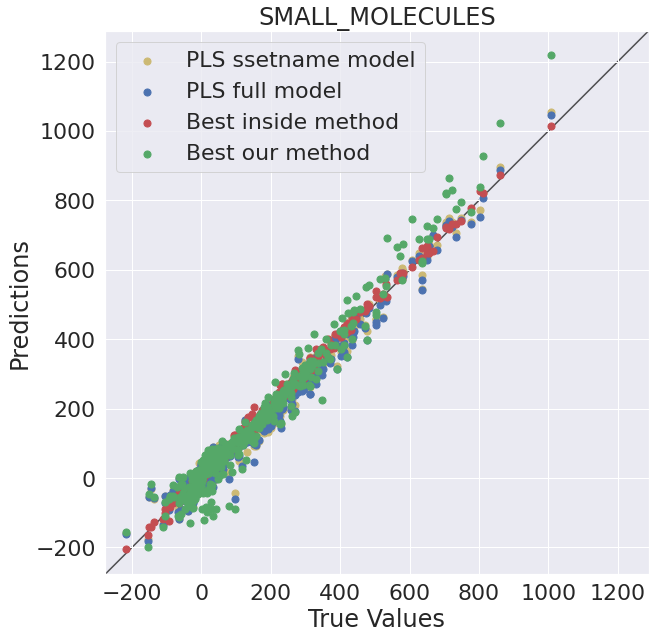

RMSE           (ssetname)  21.517
RMSE               (Full)  12.755
RMSE   (bestinsidemethod)   2.505
RMSE      (bestourmethod)  14.374


<Figure size 720x720 with 0 Axes>

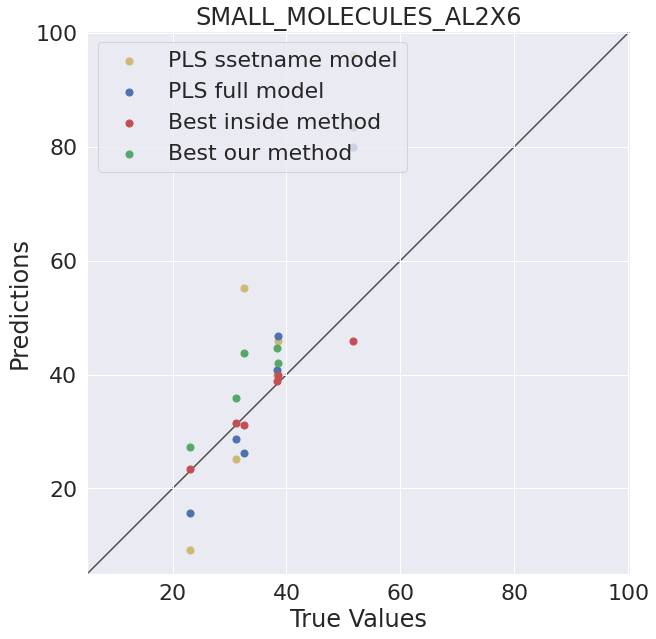

RMSE           (ssetname)  22.806
RMSE               (Full)  11.864
RMSE   (bestinsidemethod)   3.553
RMSE      (bestourmethod)  13.393


<Figure size 720x720 with 0 Axes>

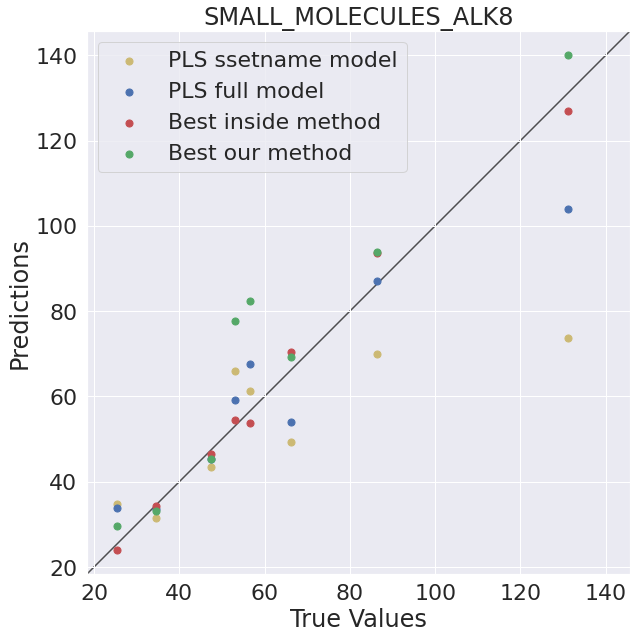

RMSE           (ssetname)  50.636
RMSE               (Full)  59.022
RMSE   (bestinsidemethod)  10.191
RMSE      (bestourmethod)  70.527


<Figure size 720x720 with 0 Axes>

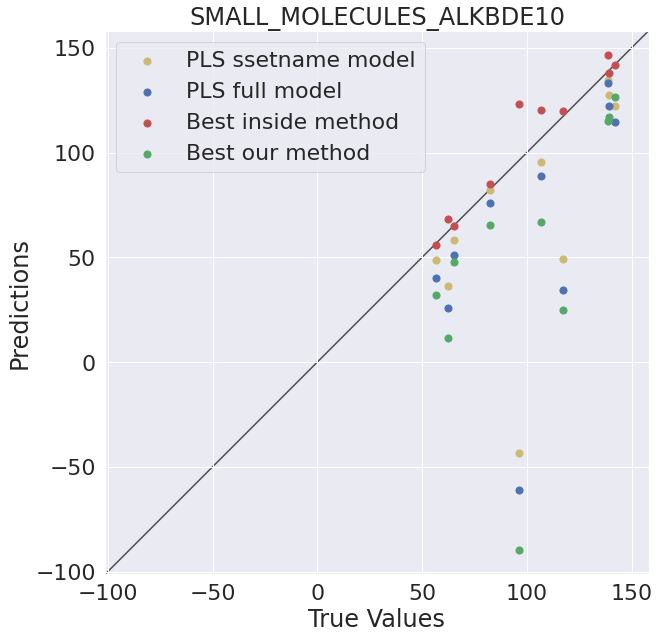

RMSE           (ssetname)  21.749
RMSE               (Full)  21.458
RMSE   (bestinsidemethod)   6.040
RMSE      (bestourmethod)  31.360


<Figure size 720x720 with 0 Axes>

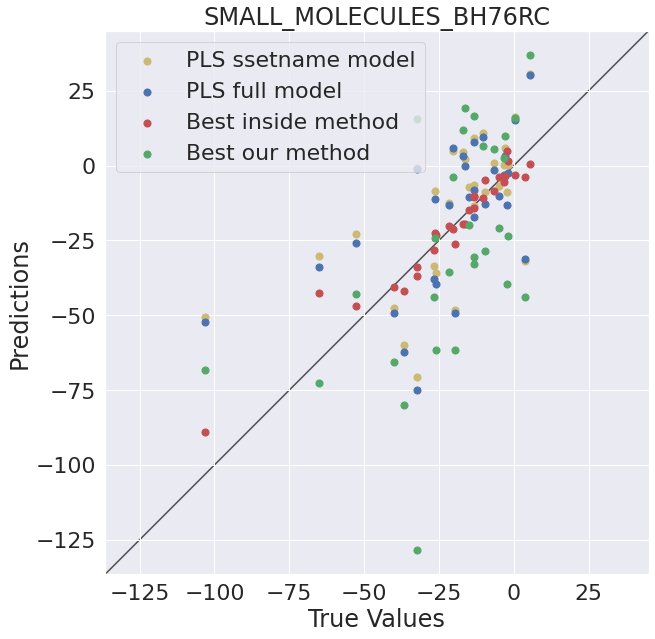

RMSE           (ssetname)  38.150
RMSE               (Full)  40.442
RMSE   (bestinsidemethod)  12.167
RMSE      (bestourmethod)  32.193


<Figure size 720x720 with 0 Axes>

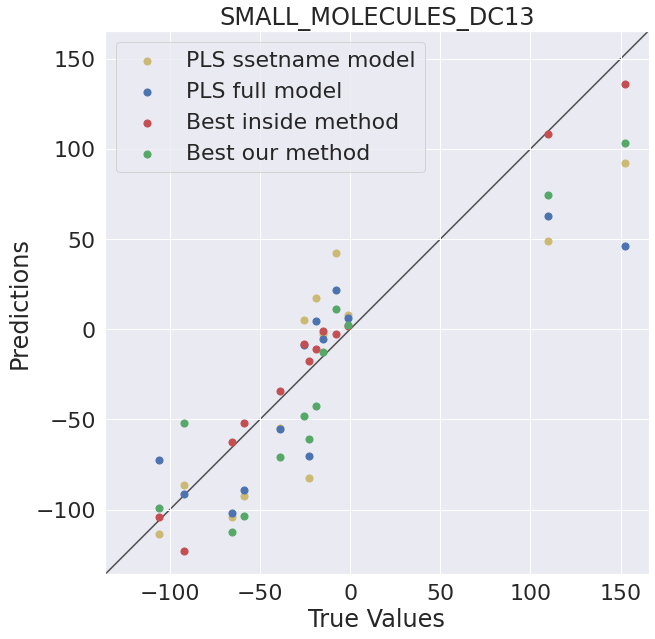

RMSE           (ssetname)  43.429
RMSE               (Full)  43.933
RMSE   (bestinsidemethod)   5.986
RMSE      (bestourmethod)  39.667


<Figure size 720x720 with 0 Axes>

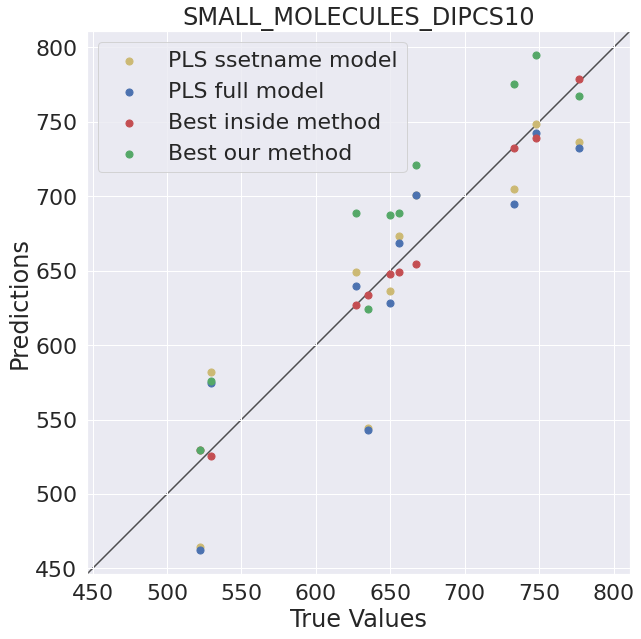

RMSE           (ssetname)  29.597
RMSE               (Full)  29.036
RMSE   (bestinsidemethod)   4.379
RMSE      (bestourmethod)  33.394


<Figure size 720x720 with 0 Axes>

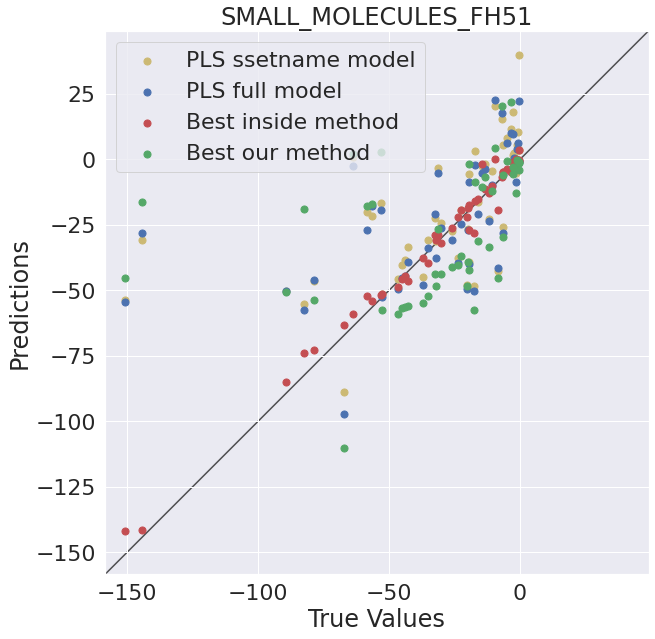

RMSE           (ssetname)  22.340
RMSE               (Full)  27.778
RMSE   (bestinsidemethod)   4.107
RMSE      (bestourmethod)  83.226


<Figure size 720x720 with 0 Axes>

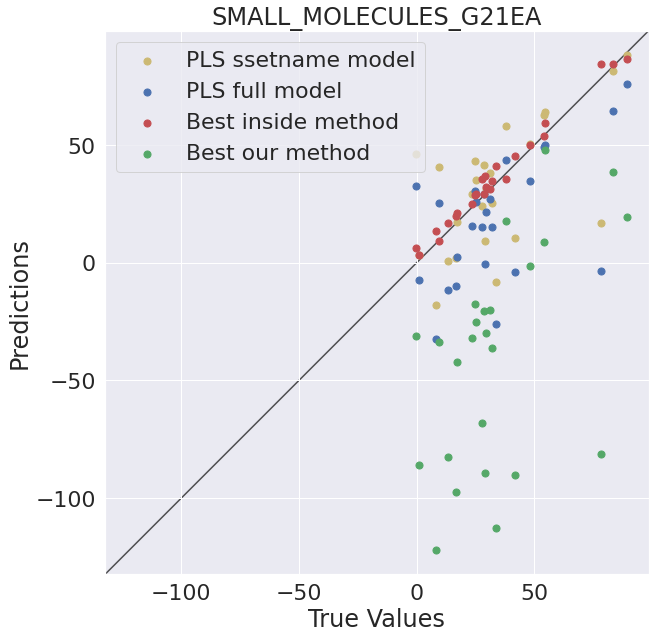

RMSE           (ssetname)  17.466
RMSE               (Full)  18.085
RMSE   (bestinsidemethod)   4.835
RMSE      (bestourmethod)  21.426


<Figure size 720x720 with 0 Axes>

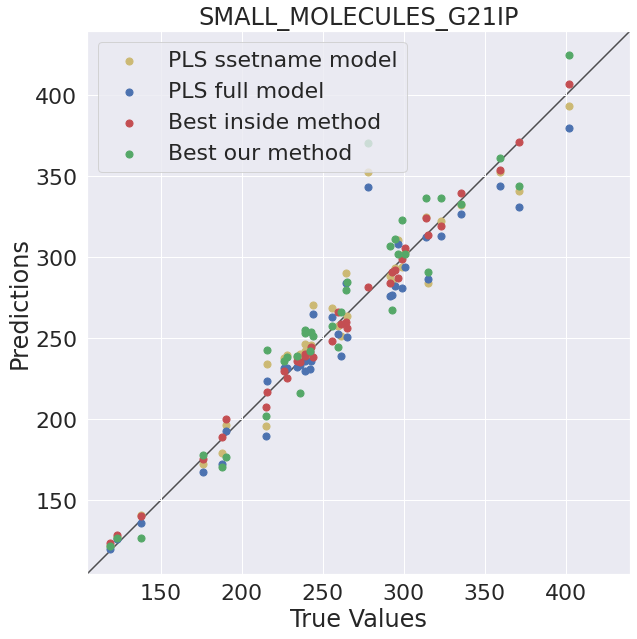

RMSE           (ssetname)  34.697
RMSE               (Full)  34.673
RMSE   (bestinsidemethod)   7.746
RMSE      (bestourmethod)  31.792


<Figure size 720x720 with 0 Axes>

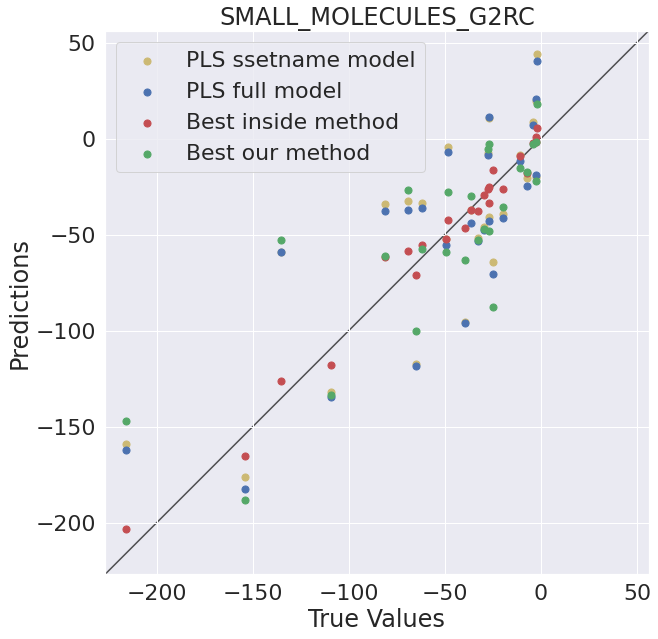

RMSE           (ssetname)  11.398
RMSE               (Full)  17.252
RMSE   (bestinsidemethod)   3.921
RMSE      (bestourmethod)   2.711


<Figure size 720x720 with 0 Axes>

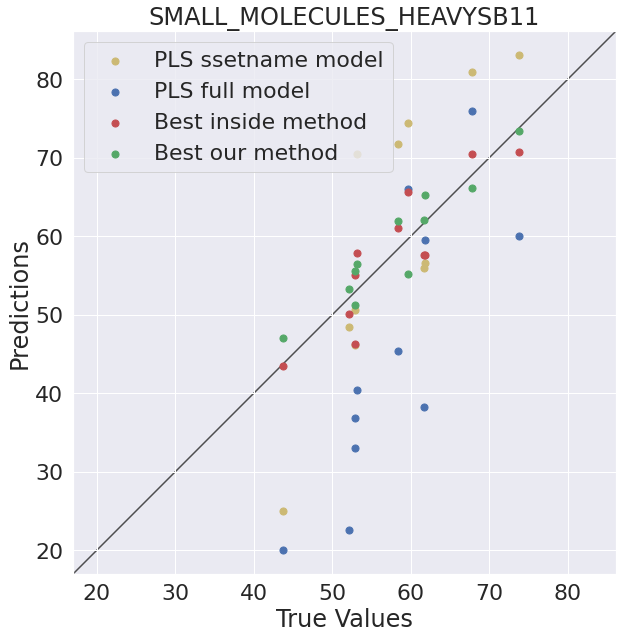

RMSE           (ssetname)  15.534
RMSE               (Full)  18.147
RMSE   (bestinsidemethod)   2.798
RMSE      (bestourmethod)  18.563


<Figure size 720x720 with 0 Axes>

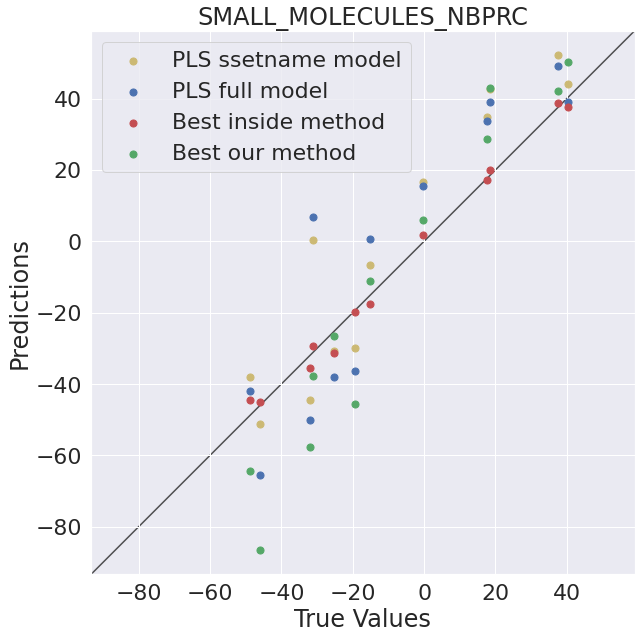

RMSE           (ssetname)  45.116
RMSE               (Full)  39.930
RMSE   (bestinsidemethod)   2.673
RMSE      (bestourmethod)  14.617


<Figure size 720x720 with 0 Axes>

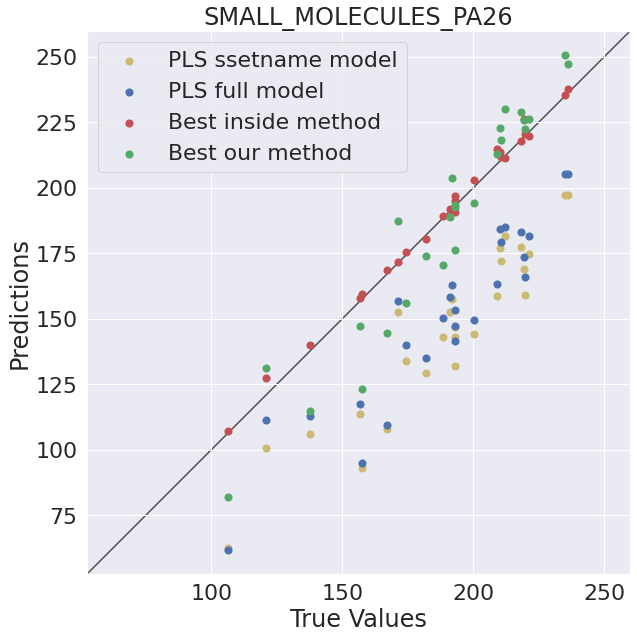

RMSE           (ssetname)  28.964
RMSE               (Full)  26.595
RMSE   (bestinsidemethod)   6.400
RMSE      (bestourmethod)  28.175


<Figure size 720x720 with 0 Axes>

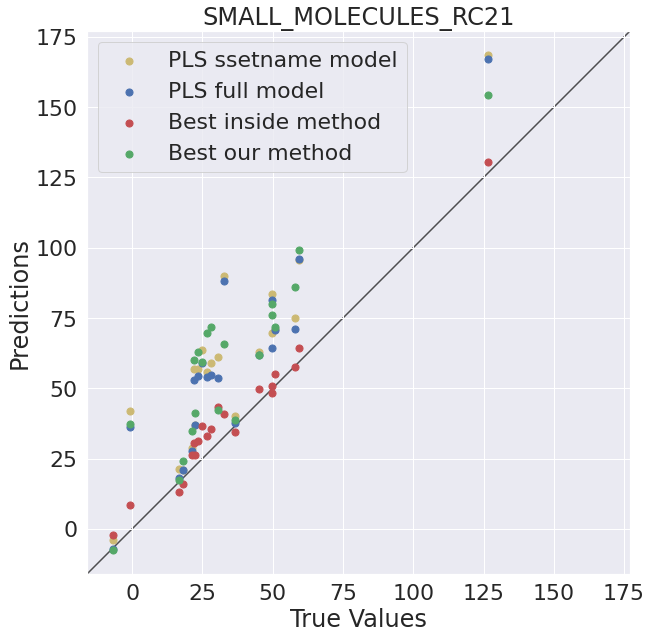

RMSE           (ssetname)  23.867
RMSE               (Full)  22.107
RMSE   (bestinsidemethod)  26.188
RMSE      (bestourmethod)  29.087


<Figure size 720x720 with 0 Axes>

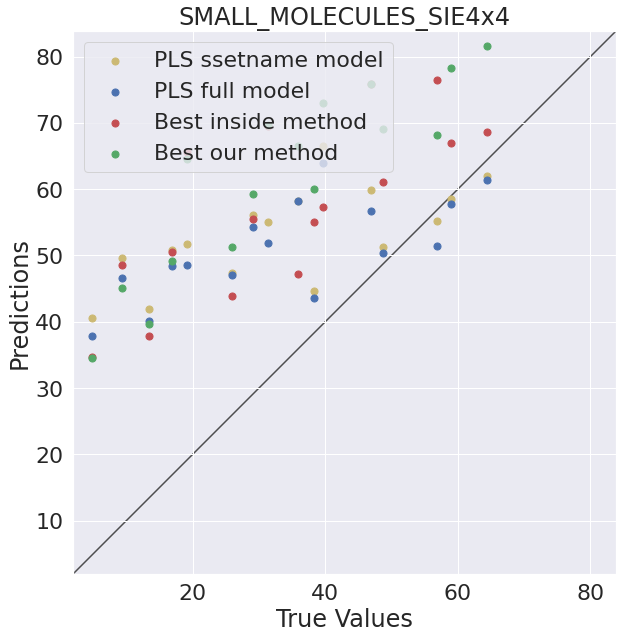

RMSE           (ssetname)  14.938
RMSE               (Full)  12.219
RMSE   (bestinsidemethod)   2.185
RMSE      (bestourmethod)   8.235


<Figure size 720x720 with 0 Axes>

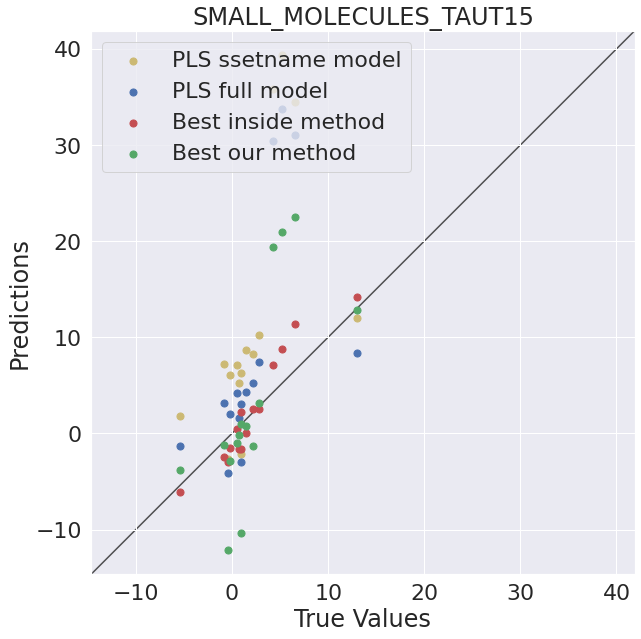

RMSE           (ssetname)  24.950
RMSE               (Full)  30.564
RMSE   (bestinsidemethod)  18.505
RMSE      (bestourmethod)  53.358


<Figure size 720x720 with 0 Axes>

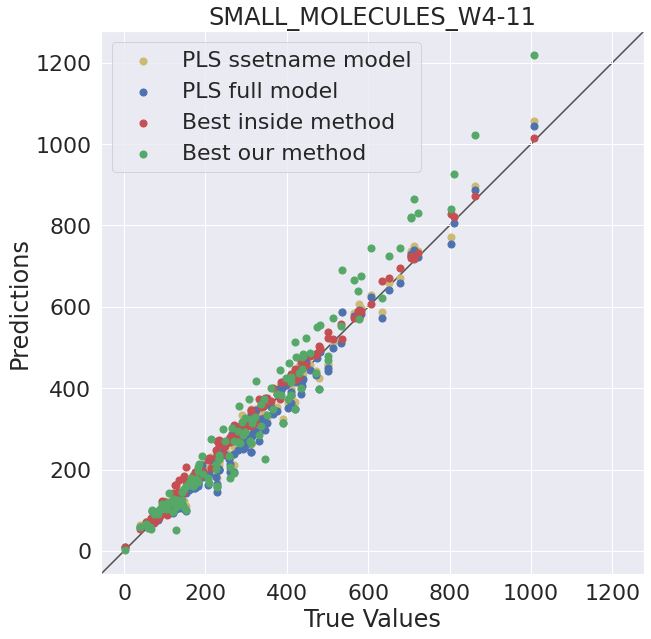

RMSE           (ssetname)  13.356
RMSE               (Full)  13.324
RMSE   (bestinsidemethod)   5.767
RMSE      (bestourmethod)  11.003


<Figure size 720x720 with 0 Axes>

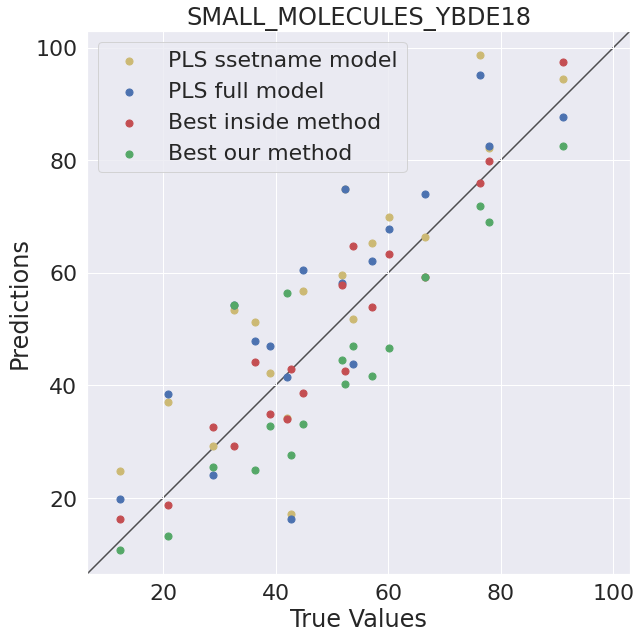

WTAMD2                     42.190
WTAMD2 (bestinsidemethod)   3.700
WTAMD2    (bestourmethod)  91.120
RMSE           (ssetname)  13.658
RMSE               (Full)  41.058
RMSE   (bestinsidemethod)   2.286
RMSE      (bestourmethod)  63.566


<Figure size 720x720 with 0 Axes>

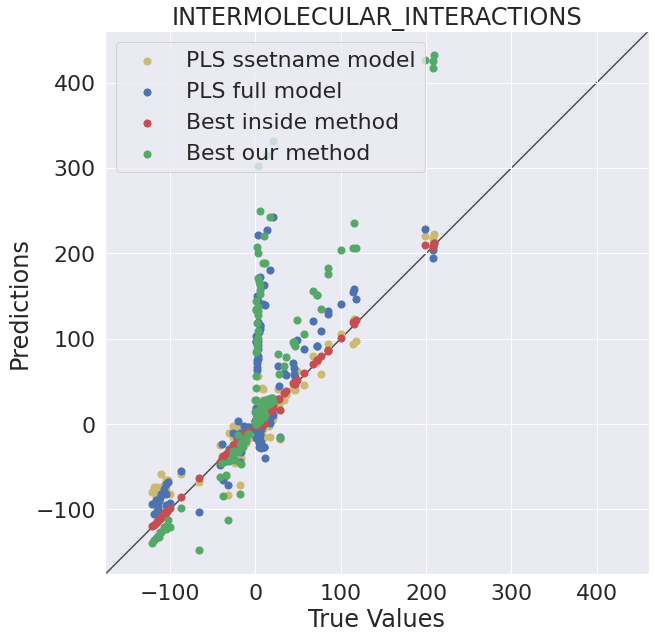

RMSE           (ssetname)   2.455
RMSE               (Full)  18.350
RMSE   (bestinsidemethod)   0.214
RMSE      (bestourmethod)   0.079


<Figure size 720x720 with 0 Axes>

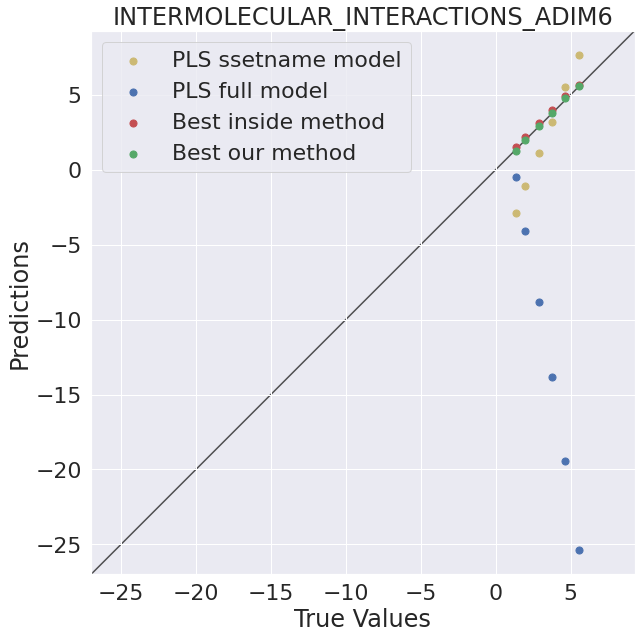

RMSE           (ssetname)  19.543
RMSE               (Full)  15.244
RMSE   (bestinsidemethod)   1.038
RMSE      (bestourmethod)  25.474


<Figure size 720x720 with 0 Axes>

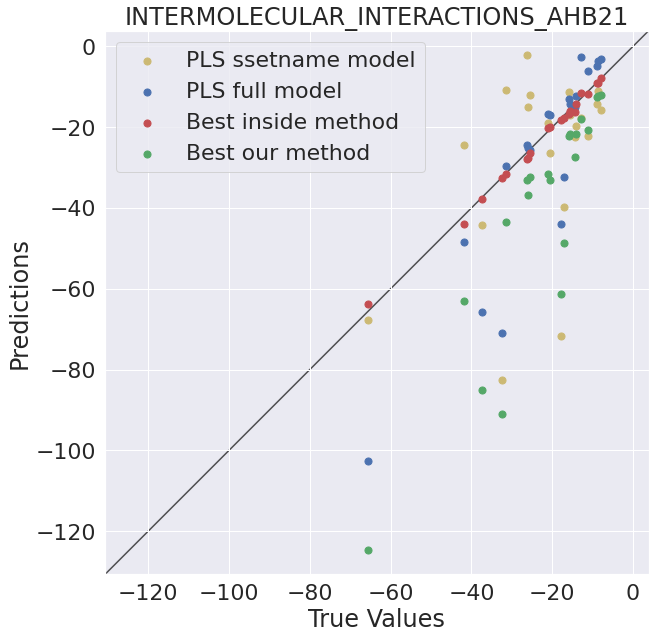

RMSE           (ssetname)   9.200
RMSE               (Full)   3.220
RMSE   (bestinsidemethod)   1.563
RMSE      (bestourmethod)   5.289


<Figure size 720x720 with 0 Axes>

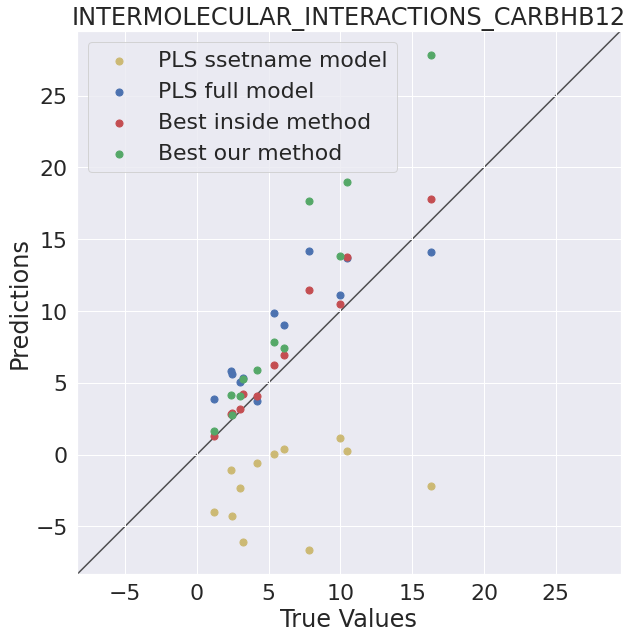

RMSE           (ssetname)  15.682
RMSE               (Full)  13.879
RMSE   (bestinsidemethod)   0.823
RMSE      (bestourmethod)  13.708


<Figure size 720x720 with 0 Axes>

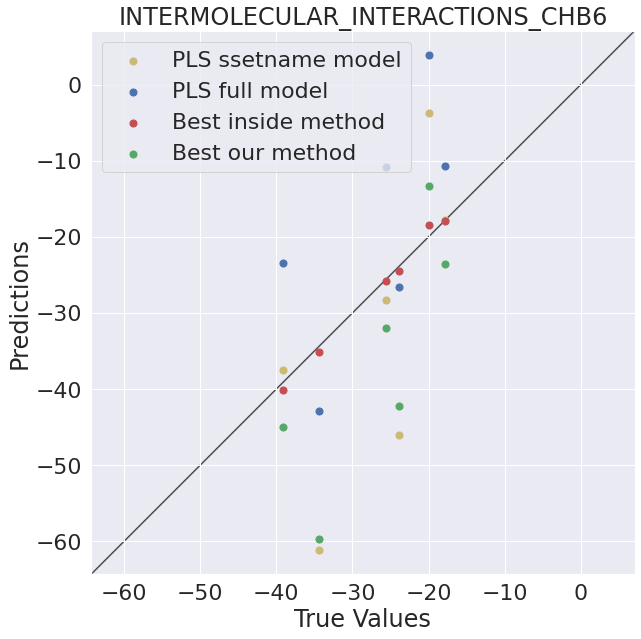

RMSE           (ssetname)  14.675
RMSE               (Full)  87.420
RMSE   (bestinsidemethod)   1.639
RMSE      (bestourmethod) 121.932


<Figure size 720x720 with 0 Axes>

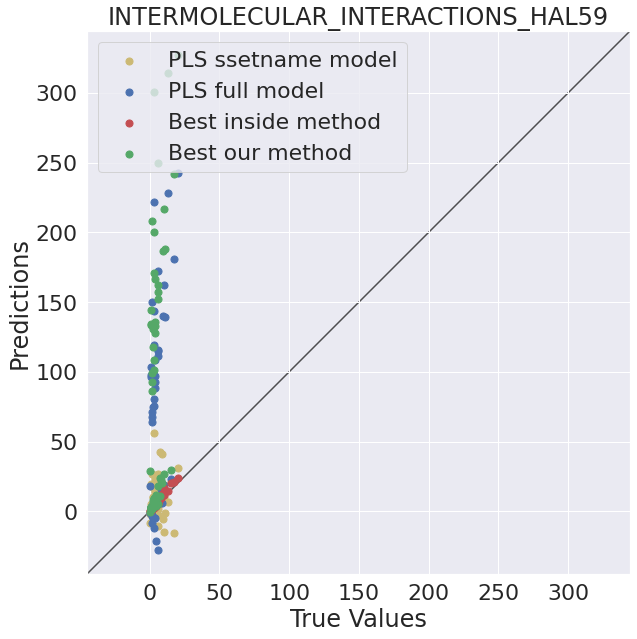

RMSE           (ssetname)   6.135
RMSE               (Full)   2.819
RMSE   (bestinsidemethod)   0.372
RMSE      (bestourmethod)   2.990


<Figure size 720x720 with 0 Axes>

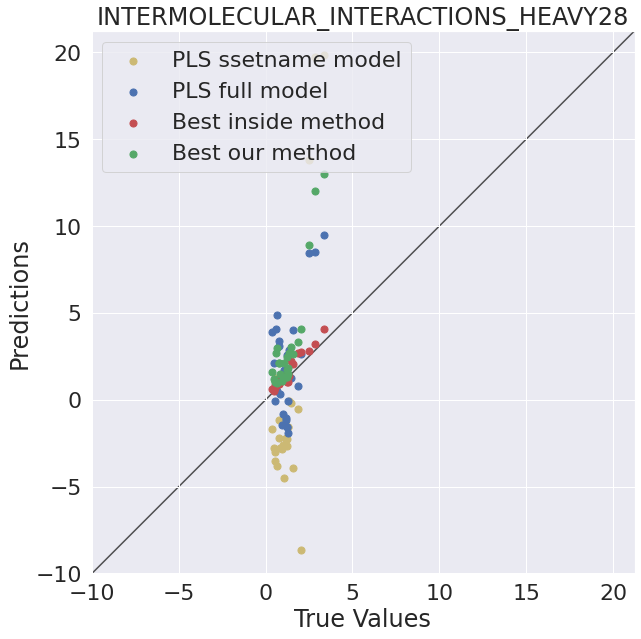

RMSE           (ssetname)  36.992
RMSE               (Full)  24.210
RMSE   (bestinsidemethod)   0.657
RMSE      (bestourmethod)  16.322


<Figure size 720x720 with 0 Axes>

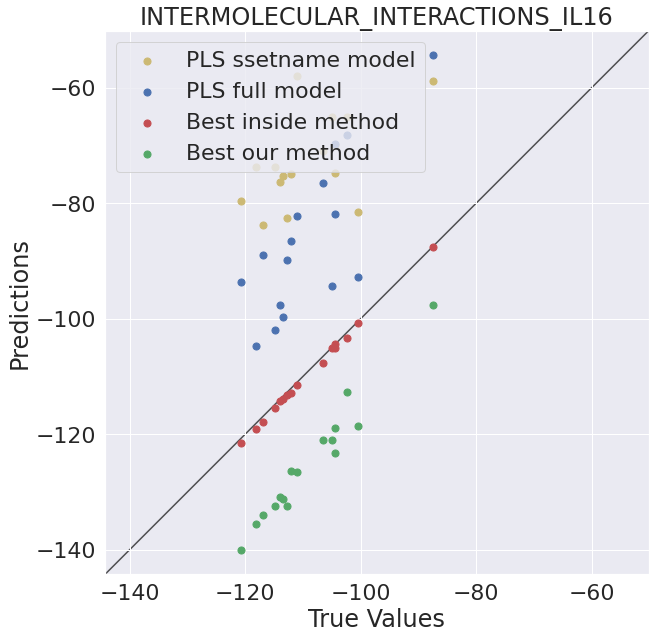

RMSE           (ssetname)   6.553
RMSE               (Full)   5.461
RMSE   (bestinsidemethod)   1.298
RMSE      (bestourmethod)   4.758


<Figure size 720x720 with 0 Axes>

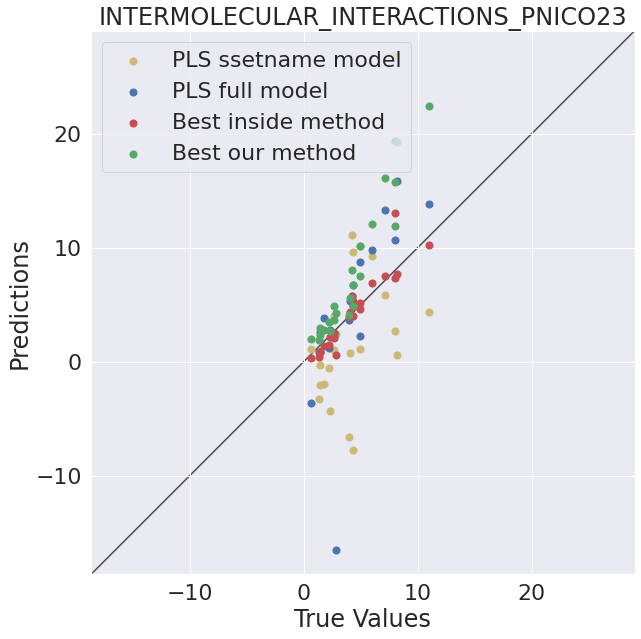

RMSE           (ssetname)   5.565
RMSE               (Full)   5.516
RMSE   (bestinsidemethod)   0.314
RMSE      (bestourmethod)   0.235


<Figure size 720x720 with 0 Axes>

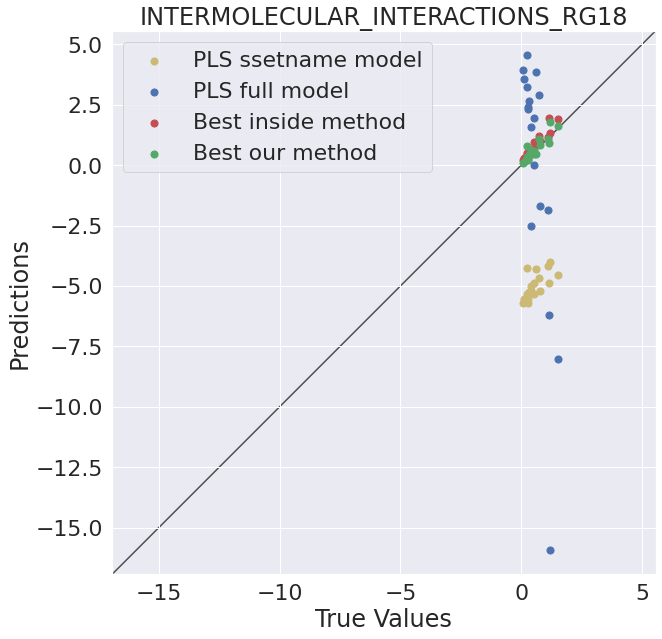

RMSE           (ssetname)   7.117
RMSE               (Full)  17.846
RMSE   (bestinsidemethod)   0.634
RMSE      (bestourmethod)   4.481


<Figure size 720x720 with 0 Axes>

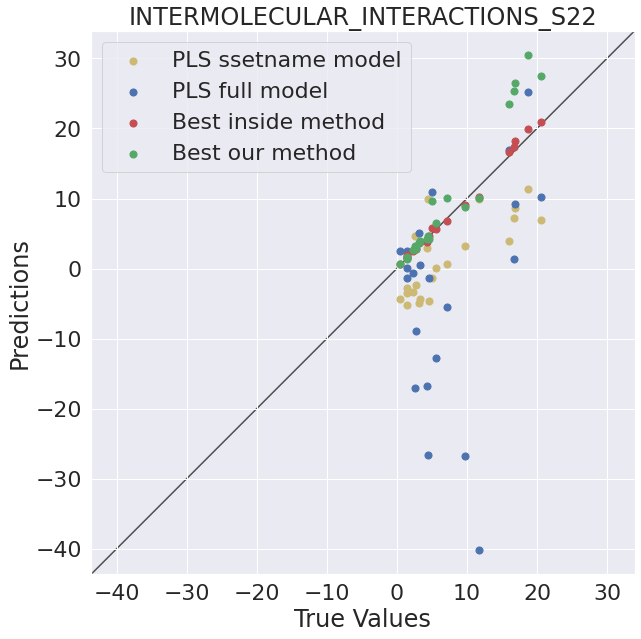

RMSE           (ssetname)   6.449
RMSE               (Full)  12.137
RMSE   (bestinsidemethod)   0.525
RMSE      (bestourmethod)   2.885


<Figure size 720x720 with 0 Axes>

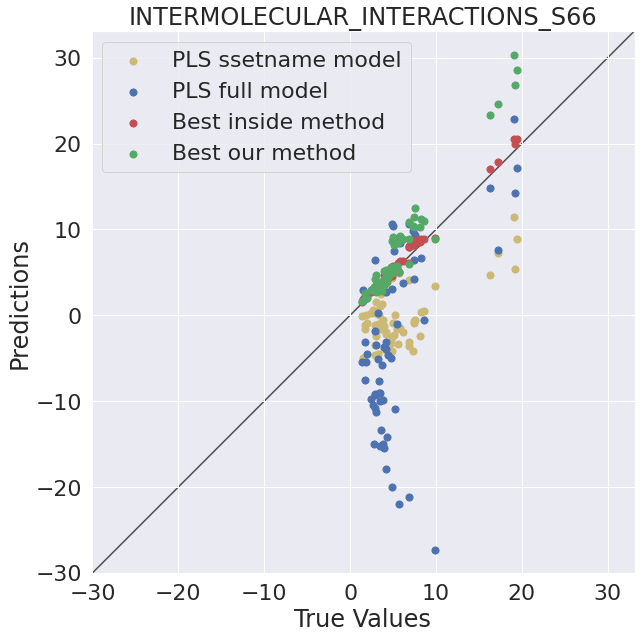

RMSE           (ssetname)  13.741
RMSE               (Full)  30.927
RMSE   (bestinsidemethod)   3.884
RMSE      (bestourmethod) 104.707


<Figure size 720x720 with 0 Axes>

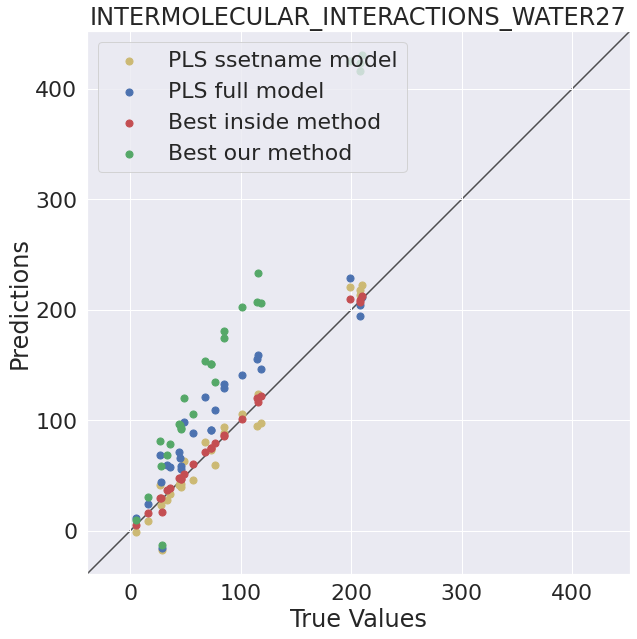

WTAMD2                     30.280
WTAMD2 (bestinsidemethod)  16.050
WTAMD2    (bestourmethod)  38.500
RMSE           (ssetname)  31.050
RMSE               (Full)  42.638
RMSE   (bestinsidemethod)  12.567
RMSE      (bestourmethod)  36.122


<Figure size 720x720 with 0 Axes>

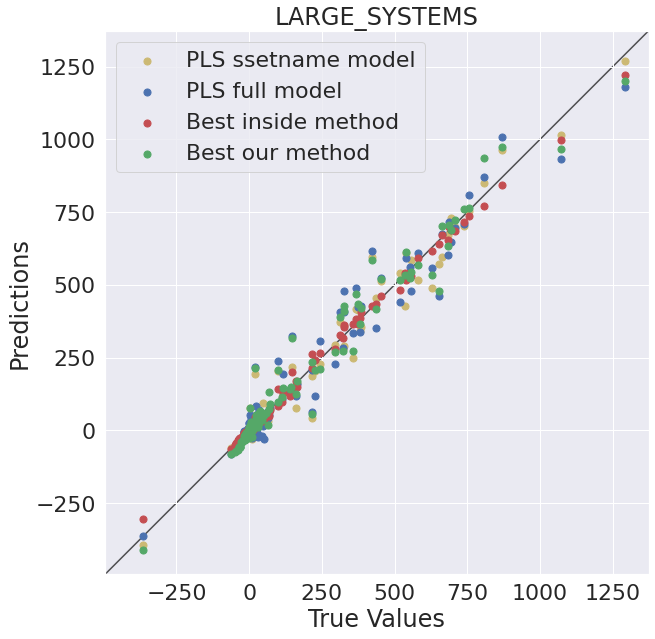

RMSE           (ssetname)   4.301
RMSE               (Full)  32.175
RMSE   (bestinsidemethod)   3.785
RMSE      (bestourmethod)   2.541


<Figure size 720x720 with 0 Axes>

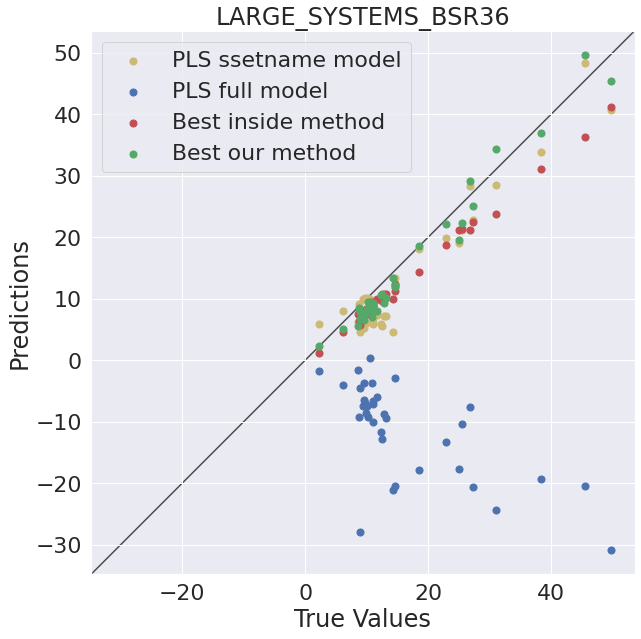

RMSE           (ssetname)   3.379
RMSE               (Full)   5.778
RMSE   (bestinsidemethod)  12.799
RMSE      (bestourmethod)   2.620


<Figure size 720x720 with 0 Axes>

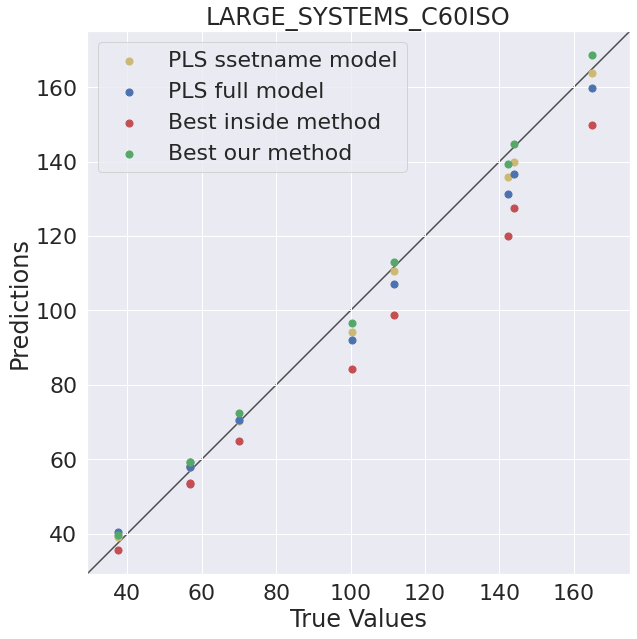

RMSE           (ssetname)   2.905
RMSE               (Full)   7.716
RMSE   (bestinsidemethod)   1.781
RMSE      (bestourmethod)   1.523


<Figure size 720x720 with 0 Axes>

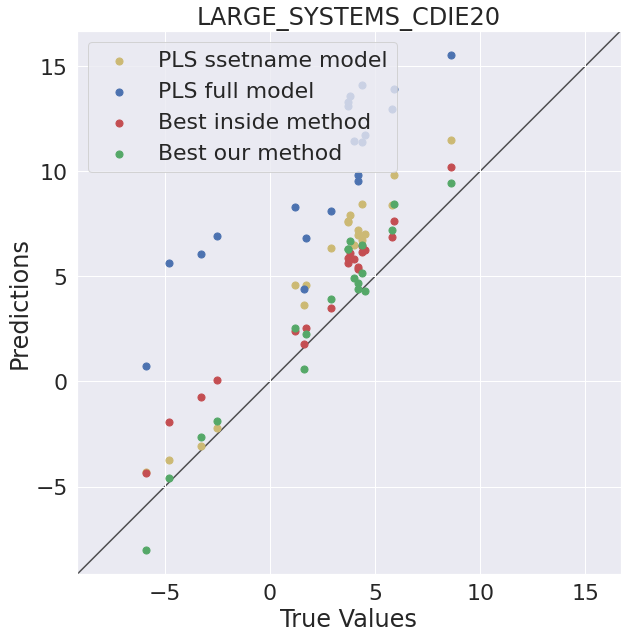

RMSE           (ssetname)   3.792
RMSE               (Full)  13.280
RMSE   (bestinsidemethod)   3.649
RMSE      (bestourmethod)  22.712


<Figure size 720x720 with 0 Axes>

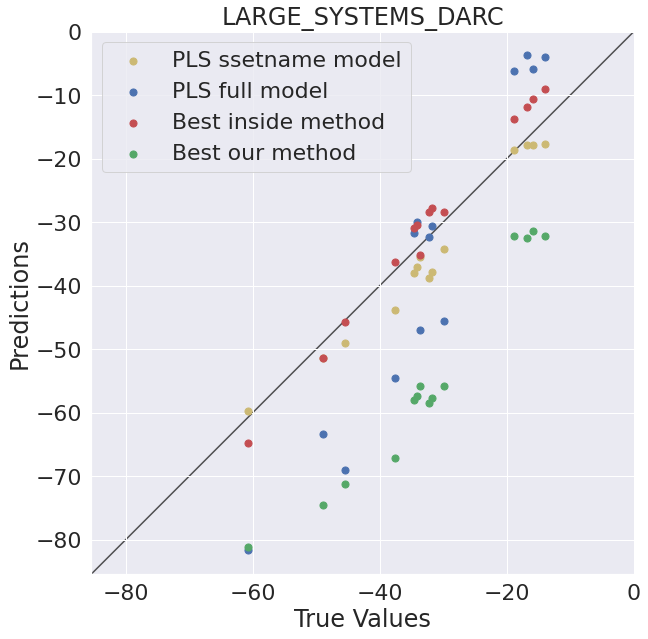

RMSE           (ssetname)   9.046
RMSE               (Full)  11.390
RMSE   (bestinsidemethod)   2.081
RMSE      (bestourmethod)  11.429


<Figure size 720x720 with 0 Axes>

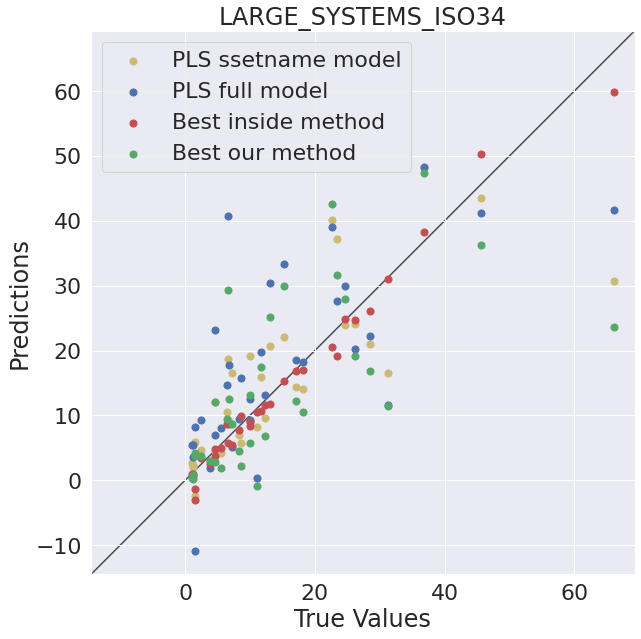

RMSE           (ssetname)  17.477
RMSE               (Full)  21.478
RMSE   (bestinsidemethod)   6.365
RMSE      (bestourmethod)  22.733


<Figure size 720x720 with 0 Axes>

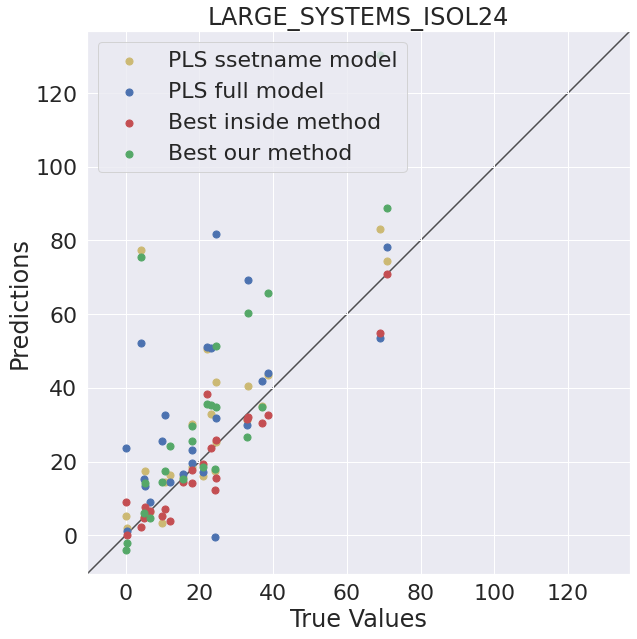

RMSE           (ssetname)  71.524
RMSE               (Full)  94.171
RMSE   (bestinsidemethod)  27.916
RMSE      (bestourmethod)  81.741


<Figure size 720x720 with 0 Axes>

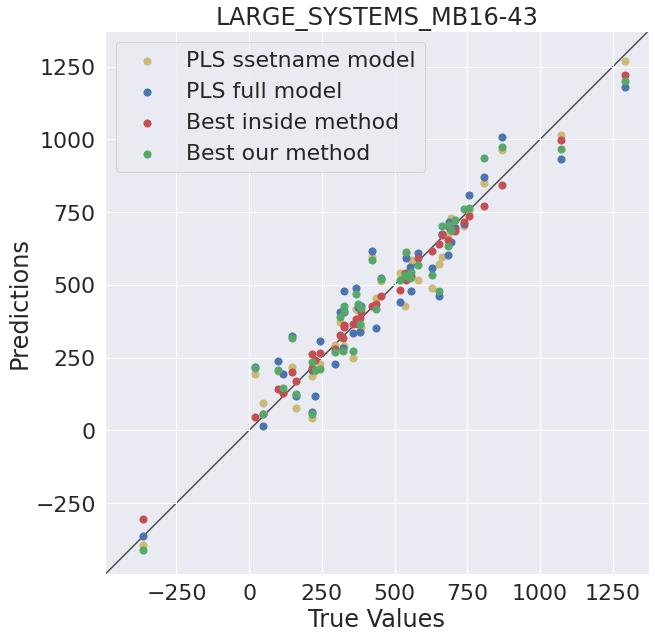

RMSE           (ssetname)  11.704
RMSE               (Full)  12.815
RMSE   (bestinsidemethod)   2.525
RMSE      (bestourmethod)  12.374


<Figure size 720x720 with 0 Axes>

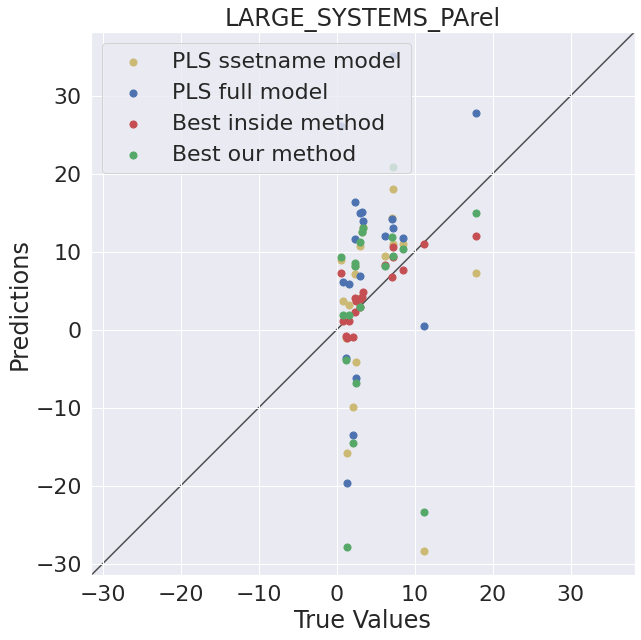

RMSE           (ssetname)   2.706
RMSE               (Full)   3.237
RMSE   (bestinsidemethod)   3.188
RMSE      (bestourmethod)   5.049


<Figure size 720x720 with 0 Axes>

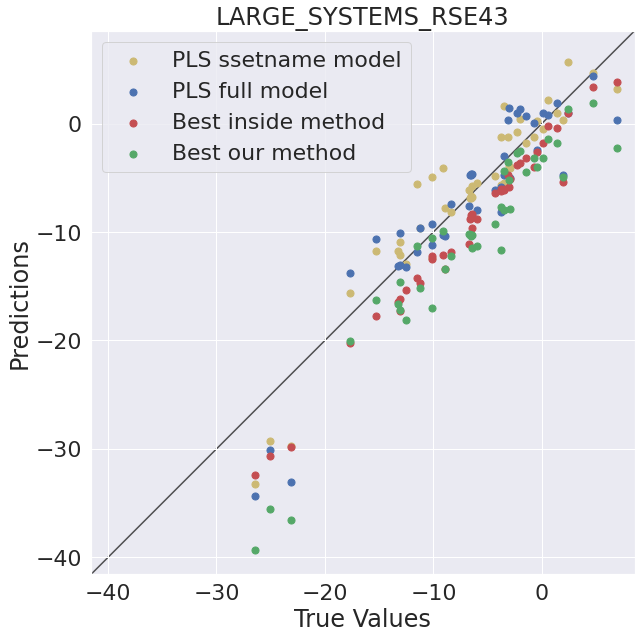

WTAMD2                     89.850
WTAMD2 (bestinsidemethod)  10.160
WTAMD2    (bestourmethod)  80.360
RMSE           (ssetname)  30.980
RMSE               (Full)  30.980
RMSE   (bestinsidemethod)   9.227
RMSE      (bestourmethod)  41.931


<Figure size 720x720 with 0 Axes>

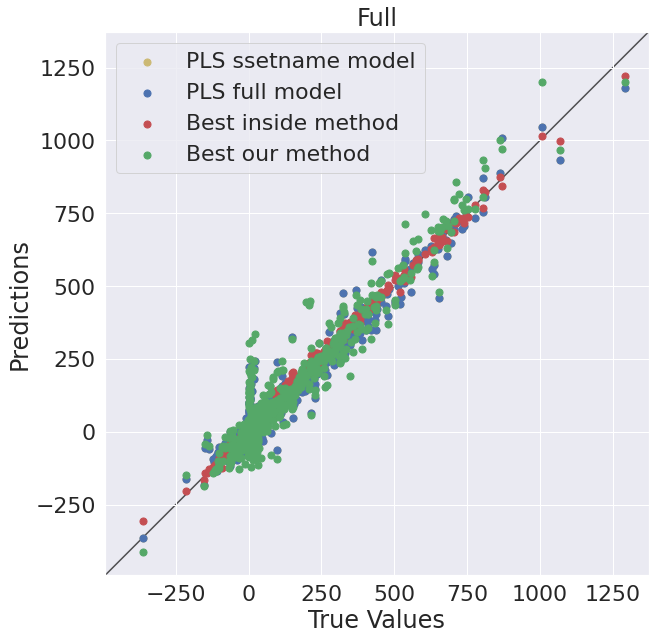

In [16]:
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    setlist = []
    for i, s in enumerate(models_results[setname].setname):
        ss = models_results[setname].supersetname[i]
        setlist.append(ss + "_" + s)   
    supersetlist = models_results[setname].supersetname
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)

    if setname in supersetnames or setname == "Full":
        wtmad2 = commonutils.wtmad_calc(supersetlist, setlist, y_pred, \
                                      Y, includeFull = True)
        print("WTAMD2                    %7.3f"%wtmad2["Full"])
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtamd) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtamd)

    print("RMSE           (ssetname) %7.3f"%rmse)
    print("RMSE               (Full) %7.3f"%rmse_full,)
    print("RMSE   (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE      (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)

    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='y', s=50, label='PLS ssetname model')
    ax.scatter(Y, y_pred_full, c='b', s=50, label='PLS full model')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()


In [17]:
#test and dump PLS equations
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:
    print("Equations for dataset: ", setname)
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)
    X_e = X.copy()
    X_e -= pls_model_full._x_mean
    X_e /= pls_model_full._x_std
    y_pred_full_e = np.dot(X_e, pls_model_full.coef_)
    y_pred_full_e += pls_model_full._y_mean
    rmse_full_e = mean_squared_error(Y, y_pred_full_e, squared=False)
    print("   Full dataset equations Y mean %7.3f"%pls_model_full._y_mean)
    for i, f in enumerate(listoffeatures_used):
        print(" %30s %7.3f [%15.3f %15.3f]"%(f, \
            pls_model_full.coef_[i],
            pls_model_full._x_mean[i], 
            pls_model_full._x_std[i]))

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    X_e = X.copy()
    X_e -= pls_model_ssetname._x_mean
    X_e /= pls_model_ssetname._x_std
    y_pred_e = np.dot(X_e, pls_model_ssetname.coef_)
    y_pred_e += pls_model_ssetname._y_mean
    rmse_e = mean_squared_error(Y, y_pred_e, squared=False)
    print("   Dataset equations Y mean %7.3f"%pls_model_ssetname._y_mean)
    for i, f in enumerate(listoffeatures_used):
        print(" %30s %7.3f [%15.3f %15.3f]"%(f, \
            pls_model_ssetname.coef_[i],
            pls_model_ssetname._x_mean[i], 
            pls_model_ssetname._x_std[i]))

    print()
    print("RMSE         (ssetname) %7.3f from eq. %7.3f diff []"%(rmse, rmse_e))
    print("RMSE             (Full) %7.3f from eq. %7.3f diff []"%(rmse_full, rmse_full_e))  
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    print()


Equations for dataset:  BARRIER_HEIGHTS
   Full dataset equations Y mean  66.230
           PBE_Potential_Energy   5.697 [         33.312         528.289]
                       PBE_E(X)  36.729 [         35.947         540.869]
        PBE_Two_Electron_Energy  47.746 [         28.062         136.511]
             PBE_Kinetic_Energy   9.927 [     -45886.512      164653.920]
      PBE_Dispersion_correction 131.977 [         70.360         172.895]
  PBE_FINAL_SINGLE_POINT_ENERGY   4.879 [         12.852          35.180]
                       PBE_E(C) -14.045 [          1.101           4.044]
   Dataset equations Y mean  23.314
           PBE_Potential_Energy  -0.290 [        -37.527         134.664]
                       PBE_E(X)   5.376 [         45.529         142.491]
        PBE_Two_Electron_Energy  13.607 [          7.611          22.274]
             PBE_Kinetic_Energy   8.246 [      11318.923       21572.716]
      PBE_Dispersion_correction  22.050 [          7.413          33.